# PM10 Forecasting Pipeline (Multi-Target)

This repository contains the code to perform multi-target time series forecasting of PM10 levels across various locations in Canton Ticino using meteorological data and historical pollutant measurements.

# Forecasting pipeline


1. **Data pre-processing and EDA**
    1.  Missing values detection and imputation
    2.  Outliers detection and treatment
    3.  Seasonality and trend analysis
    4.  Stationarity tests
    5.  Correlation analysis between locations and signals
2.  **Univariate benchmark models**
    1.  naive methods
    2.  Holt-Winters, AR(I)MAX
3.  **Model proposal and training**
    1.  Cross-validation functions
    2.  Hyperparameter tuning strategies
    3.  RNN dense, GRU and Informer models
4.  **Model evaluation**
    1.  Evaluation on the test set
    2.  Comparison with benchmark models
5.  **Forecast visualization** 
    1.  Visualization of the forecasts for each location and horizon
    2.  Visualization of the average forecast across locations
---
Understanding the relations between weather conditions and inquinants like ozone and PM10, PM2.5 is important to take in place systemic counter-measures to increase air quality.

This dataset contains measurements of PM10, chemical components and meteorological forecasts at different hours of the day related to various locations of Canton Ticino.

The dataset refers to the period 2016-2022 and has been provided by [OASI](https://www.oasi.ti.ch/web/esplora-dati/). The forecasted weather conditions have been obtained through the [COSMO and COSMO2 models](https://www.notion.so/fd5a606c07144109bc080ec595f6295d?pvs=21), which is tune to produce accurate forecasts in the topographically challenging Alpine region.

The following tables summarize the name of the variables and locations present in the dataset: The naming convention in the dataset is the following:

- $LOCATION__$SIGNAL__$HOUR for measurements
- $LOCATION__$SIGNAL__$STEP for meteorological forecasts
- $LOCATION__$SIGNAL__$DAY_AHEAD for the target

---
## Challenge:

The task is to produce the 1-6 days ahead forecasts of the daily mean of the PM10 quantity (already provided in the last columns of the dataset, e.g. BRI__YPM10-dailymean__d3 for the 3 days ahead value in Brione) **for all the provided locations AND their average**.


1. **Trained Model(s)** that can predict PM10 levels 1-6 days ahead
2. **Predictions for ALL locations** (9 locations × 6 days = 54 predictions per date)
3. **Average predictions** (6 average values per date, one per day-ahead)
4. **Model Evaluation** comparing your model against simple benchmarks
5. **Visualizations** showing your forecasts


# Libraries and functions import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

1. **Data pre-processing and EDA**
2.  Seasonality and trend analysis
3.  Stationarity tests
4.  Correlation analysis between locations and signals

## 1 - Data Loading and Overview

In [2]:
df = pd.read_csv('archive/data.csv', index_col='date', parse_dates=True)
print(f"Data shape: {df.shape}")
print(f"Columns: {len(df.columns)} columns")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Data shape: (2557, 8536)
Columns: 8536 columns
Date range: 2016-01-01 00:00:00 to 2022-12-31 00:00:00


## 1 - Target and Features Extraction

In [3]:
target_name = "YPM10-dailymean"

target_cols = [col for col in df.columns if target_name in col]
features_cols = [col for col in df.columns if target_name not in col]
print(f"Target columns: {len(target_cols)}")
print(f"Feature columns: {len(features_cols)}")



Target columns: 48
Feature columns: 8488


## 1 - Get locations


In [4]:
locations = sorted(list(set([c.split('__')[0] for c in target_cols])))
print(f"Locations: {locations}")

Locations: ['BIO', 'BRI', 'CHI', 'GIU', 'LOC', 'LUG', 'MEN', 'NA-MAG']


## 1. Calculate average 

The challenge asked to predict the average PM10 levels across all locations. To do so, we calculate the mean of the PM10 values for each time step.

In [5]:
days_ahead = sorted(list(set([c.split('__')[-1] for c in target_cols]))) # e.g., ['d0', 'd1', ..., 'd5']
print(f"Days ahead: {days_ahead}")

Days ahead: ['d0', 'd1', 'd2', 'd3', 'd4', 'd5']


In [6]:
X_train = df[features_cols]
y_train = df[target_cols]
y_avg = pd.DataFrame(index=y_train.index)

for day in days_ahead:
    # Find all columns for the current day
    day_cols = [col for col in target_cols if col.endswith(f'__{day}')]
    avg_col_name = f"AVG__YPM10-dailymean__{day}"
    y_avg[avg_col_name] = y_train[day_cols].mean(axis=1)
    print(f"processed: {avg_col_name}")

#drop the other ones ending with 

processed: AVG__YPM10-dailymean__d0
processed: AVG__YPM10-dailymean__d1
processed: AVG__YPM10-dailymean__d2
processed: AVG__YPM10-dailymean__d3
processed: AVG__YPM10-dailymean__d4
processed: AVG__YPM10-dailymean__d5


In [7]:
y_train = pd.concat([y_avg], axis=1)
print(f"y_train shape after adding averages: {y_train.shape}")
y_train.columns

y_train shape after adding averages: (2557, 6)


Index(['AVG__YPM10-dailymean__d0', 'AVG__YPM10-dailymean__d1',
       'AVG__YPM10-dailymean__d2', 'AVG__YPM10-dailymean__d3',
       'AVG__YPM10-dailymean__d4', 'AVG__YPM10-dailymean__d5'],
      dtype='object')

In [8]:
forecast_features = [col for col in features_cols if '__step' in col]
#extract only forecast features (step0, step1, etc.) and check uniqueness of signals
signals_in_forecasts = set()
for col in forecast_features:
    signal = col.split('__')[1]
    signals_in_forecasts.add(signal)
print(f"Signals in forecast features: {signals_in_forecasts}")

Signals in forecast features: {'GLOB_c2', 'TD_2M_c2', 'PS', 'RELHUM_2M', 'FF_10M', 'T_2M_c2', 'T_2M', 'TOT_PREC_c2', 'TOT_PREC', 'PS_c2', 'CLCT_c2', 'CLCT', 'RELHUM_2M_c2', 'DD_10M', 'TD_2M', 'GLOB'}


## 1. Feature Explanations

The dataset's features include historical measurements and meteorological data across various locations in Canton Ticino. The "pollutants" (or signals) extracted from the features are a mix of air pollutants and weather variables, all with lagged versions (e.g., m0 for current, m1 for 1 step back) and forecast steps (step0 through step5). Below is an explanation of each signal based on standard air quality and meteorological conventions. 

**Important Note:** PM10 is our target variable and has been removed from X_train to prevent data leakage. PM10 only appears in y_train as the variable we're predicting.

| Signal | Full Name/Description |
|--------|-----------------------|
| WSgust | Wind Speed Gust – Maximum short-term wind speed, indicating potential for pollutant dispersion or advection. |
| O3     | Ozone – A secondary pollutant formed by chemical reactions; high levels can indicate photochemical smog and affect air quality. |
| CN     | Carbon Monoxide? (or possibly another carbon-based pollutant) – Likely a measure of carbon monoxide or a related compound; toxic gas from combustion. |
| WDvect | Wind Direction Vector – Vector representation of wind direction (e.g., x/y components), useful for modeling wind patterns. |
| D_T_T  | Temperature Difference (possibly dew point or gradient) – Difference in temperature values, potentially between surface and air or over time. |
| Prec   | Precipitation – Amount of rainfall or snow, which can wash out pollutants or influence humidity. |
| T      | Temperature – Air temperature, a key meteorological factor affecting pollutant formation and dispersion. |
| D_P_P  | Pressure Difference – Gradient or change in atmospheric pressure, influencing weather systems and pollutant transport. |
| RH     | Relative Humidity – Percentage of moisture in the air, impacting pollutant reactions and health effects. |
| WSvect | Wind Speed Vector – Vector representation of wind speed (e.g., u/v components), for directional wind modeling. |
| NO     | Nitrogen Monoxide – Primary pollutant from vehicle emissions; precursor to NO2 and ozone. |
| NO2    | Nitrogen Dioxide – Toxic gas from combustion; contributes to acid rain and respiratory issues. |
| Gl     | Global Radiation – Incoming solar radiation, influencing photochemical reactions like ozone formation. |
| Tdew   | Dew Point Temperature – Temperature at which air becomes saturated; indicates humidity levels. |
| WS     | Wind Speed – Average wind speed, affecting pollutant dilution and transport. |
| WD     | Wind Direction – Direction from which the wind blows, important for source attribution of pollutants. |
| NOx    | Nitrogen Oxides – Combined NO and NO2; indicator of traffic-related pollution. |
| P      | Atmospheric Pressure – Barometric pressure, influencing weather stability and pollutant accumulation. |

These features are available as lagged measurements (e.g., __m0 to __m20) and forecast steps (__step0 to __step5) to capture temporal dependencies. Meteorological signals (e.g., T, RH, WS) are often more complete and help predict PM10 by incorporating weather influences and historical pollutant trends.

## Plot PM10 Time Series by Station

Plot the PM10 target values (daily mean) for each station across all prediction horizons (d0 through d5).

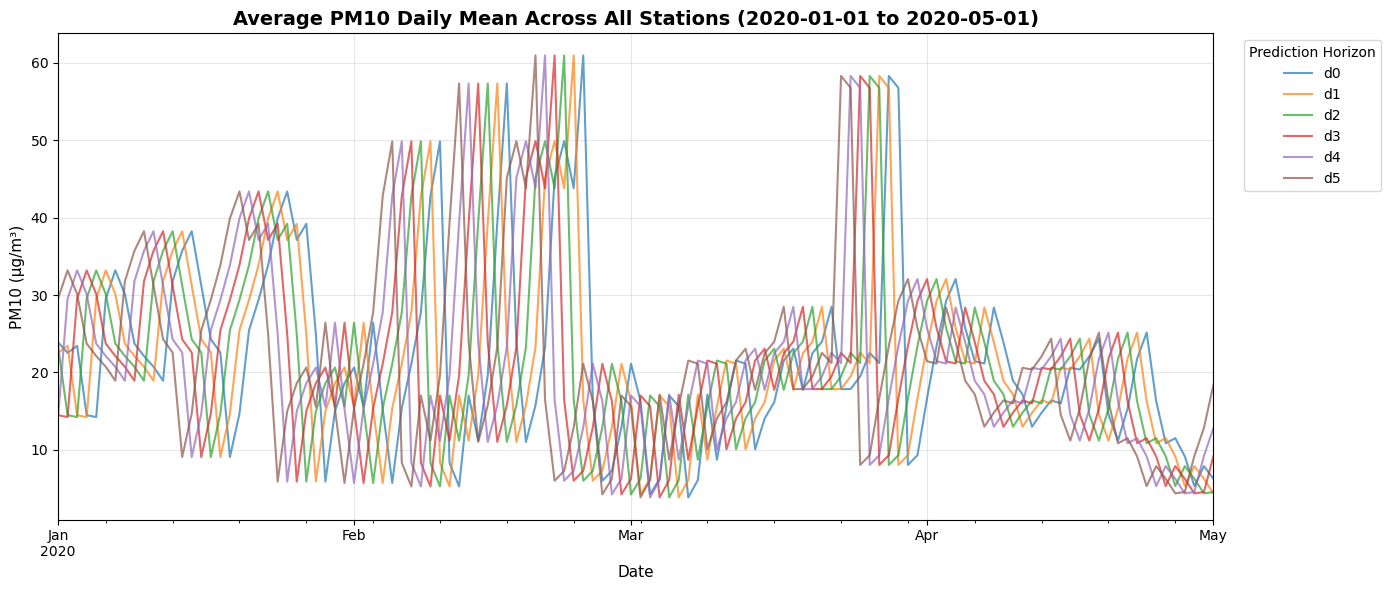

In [9]:
# Plot average PM10 time series across all stations for each prediction horizon
# Plot only a portion of the dataset (e.g., 2020-2021 for clearer visualization)
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Select a portion of the data - modify dates as needed
start_date = '2020-01-01'
end_date = '2020-05-01'


y_avg_subset = y_avg.loc[start_date:end_date]

# Plot all prediction horizons from y_avg
y_avg_subset.plot(ax=ax, alpha=0.7, linewidth=1.5)

ax.set_title(f'Average PM10 Daily Mean Across All Stations ({start_date} to {end_date})', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('PM10 (µg/m³)', fontsize=11)
ax.legend(title='Prediction Horizon', labels=[col.split('__')[-1] for col in y_avg.columns], 
          bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1. Feature visualization

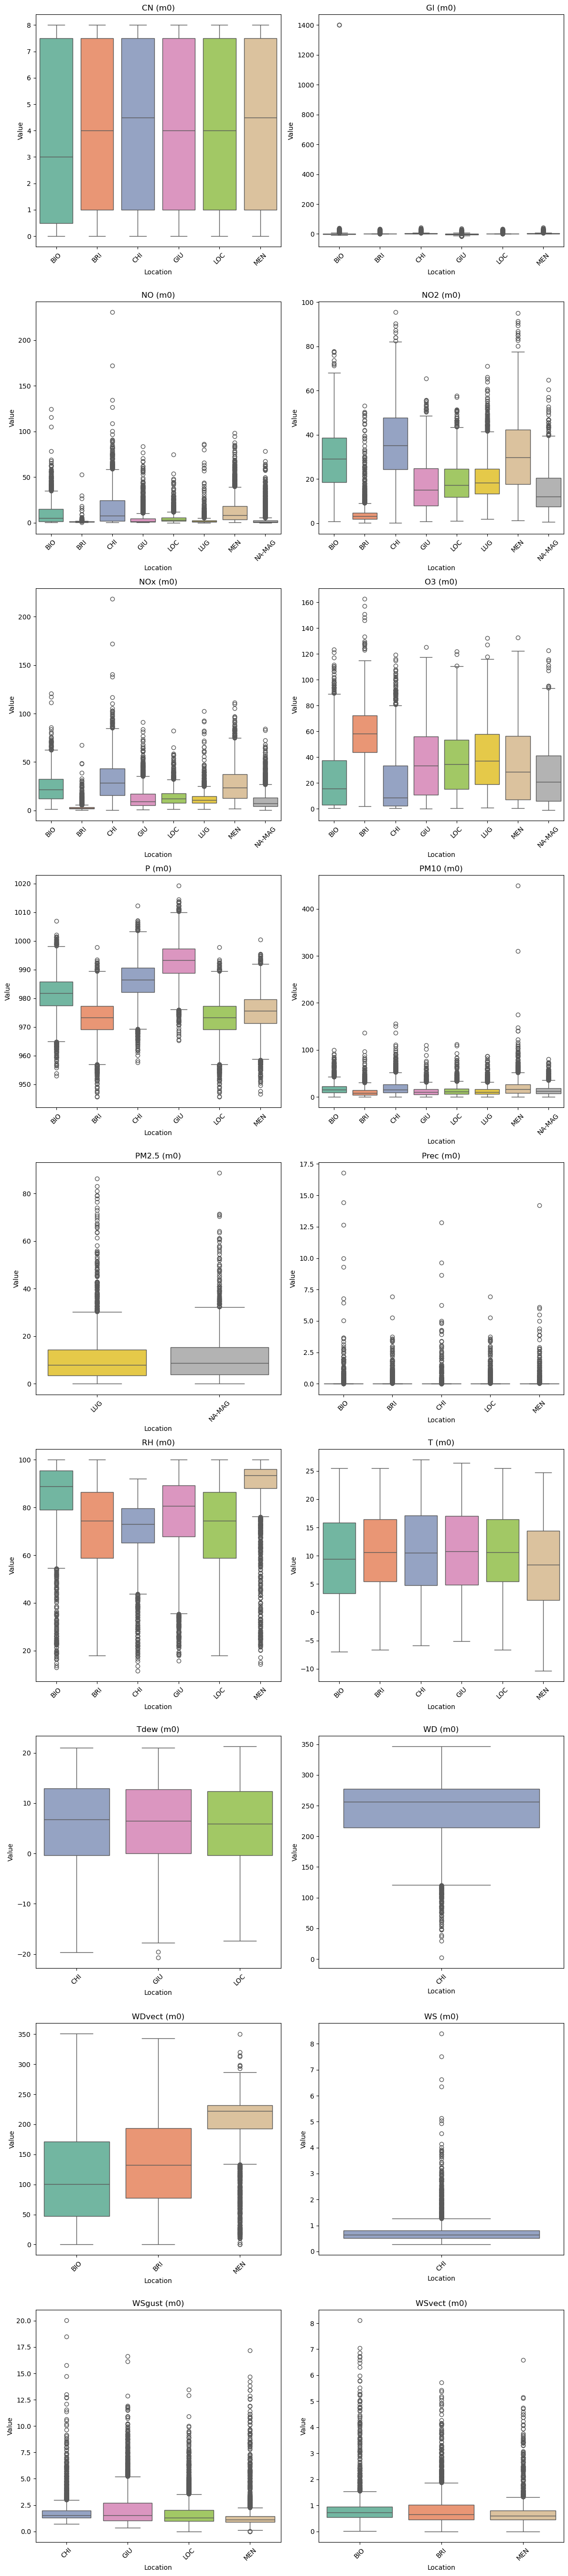

In [10]:
# Box plots per feature (signal) with all locations on the same chart in a 2x10 grid
m0_features = [col for col in features_cols if col.endswith('__m0')]

# Get all unique signals across locations that have data
all_signals = []
for signal in sorted(set([col.split('__')[1] for col in m0_features])):
    has_data = False
    for loc in locations:
        col_name = f'{loc}__{signal}__m0'
        if col_name in X_train.columns and not X_train[col_name].dropna().empty:
            has_data = True
            break
    if has_data:
        all_signals.append(signal)

# Define consistent color palette for locations
location_palette = {loc: color for loc, color in zip(sorted(locations), sns.color_palette('Set2', len(locations)))}

# Adjust grid size based on number of signals
n_signals = len(all_signals)
n_cols = 2
n_rows = (n_signals + n_cols - 1) // n_cols  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6 * n_rows))
axes = axes.flatten()

for i, signal in enumerate(all_signals):
    ax = axes[i]
    # Collect data for this signal across all locations
    signal_data = []
    location_labels = []
    for loc in locations:
        col_name = f'{loc}__{signal}__m0'
        if col_name in X_train.columns:
            data = X_train[col_name].dropna()
            if not data.empty:
                signal_data.append(data)
                location_labels.extend([loc] * len(data))
    
    # Combine into a DataFrame for plotting
    combined_data = pd.DataFrame({
        'Value': pd.concat(signal_data),
        'Location': location_labels
    })
    
    # Sort by location for consistent order
    combined_data = combined_data.sort_values('Location')
    
    sns.boxplot(data=combined_data, x='Location', y='Value', ax=ax, hue='Location', palette=location_palette, legend=False, showfliers=True)
    ax.set_title(f'{signal} (m0)')
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(n_signals, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

NA-MAG and LUG seems to be different stations with a different set of features, possibly due to their specific measurement setups or data availability and not all the stations have all the features listed above.

In [11]:
# Features per station (m0 measurements)
features_per_station = {}
for loc in locations:
    loc_features = [col for col in m0_features if col.startswith(f'{loc}__')]
    signals = sorted([col.split('__')[1] for col in loc_features])
    features_per_station[loc] = signals

for loc, signals in features_per_station.items():
    print(f"{loc}: {signals}")

#common features across all stations
common_features = set(features_per_station[locations[0]])
for loc in locations[1:]:
    common_features.intersection_update(set(features_per_station[loc]))
print(f"Common features across all stations: {sorted(common_features)}")

BIO: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'WDvect', 'WSvect']
BRI: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'WDvect', 'WSvect']
CHI: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'Tdew', 'WD', 'WS', 'WSgust']
GIU: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'RH', 'T', 'Tdew', 'WSgust']
LOC: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'Tdew', 'WSgust']
LUG: ['NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5']
MEN: ['CN', 'Gl', 'NO', 'NO2', 'NOx', 'O3', 'P', 'PM10', 'Prec', 'RH', 'T', 'WDvect', 'WSgust', 'WSvect']
NA-MAG: ['NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5']
Common features across all stations: ['NO', 'NO2', 'NOx', 'O3', 'PM10']


## Drop PM10 from Features

Since PM10 is our target variable (we're predicting the average PM10 across locations), we must remove all PM10 features from X_train to avoid data leakage. PM10 values should only exist in y_train.

## Create Lagged PM10 Features Before Dropping

Before dropping PM10, we create lagged features from each station's PM10 measurements. These will be used in hierarchical clustering and modeling.

In [12]:
# Create lagged PM10 features for each station from their PM10__m0 columns
print("="*80)
print("CREATING LAGGED PM10 FEATURES FOR EACH STATION")
print("="*80)

# Get PM10 m0 columns for each location
pm10_m0_cols = [col for col in X_train.columns if '__PM10__m0' in col and not col.startswith('AVG')]

lag_columns_to_add = {}
n_lags = 1

for pm10_col in pm10_m0_cols:
    # Extract location from column name (e.g., 'BIO__PM10__m0' -> 'BIO')
    loc = pm10_col.split('__')[0]
    
    # Get the PM10 values for this location
    pm10_values = X_train[pm10_col]
    
    # Create lagged features for this location (lags 1 to 20)
    for lag in range(1, n_lags + 1):
        lag_col_name = f"{loc}__PM10_lag{lag}__m0"
        lag_columns_to_add[lag_col_name] = pm10_values.shift(lag)

# Add all lagged columns to X_train
if lag_columns_to_add:
    lag_df = pd.DataFrame(lag_columns_to_add, index=X_train.index)
    X_train = pd.concat([X_train, lag_df], axis=1)
    
    print(f"✓ Created {len(lag_columns_to_add)} lagged PM10 features across {len(pm10_m0_cols)} stations")
    print(f"  Sample columns: {list(lag_columns_to_add.keys())[:5]}...")
    print(f"  New X_train shape: {X_train.shape}")
    
    # Impute missing values in lagged features
    missing_before = lag_df.isnull().sum().sum()
    print(f"  Missing values in lagged features (before imputation): {missing_before}")
    
    # Forward and backward fill
    for lag_col in lag_columns_to_add.keys():
        X_train[lag_col] = X_train[lag_col].ffill().bfill()
    
    missing_after = X_train[[col for col in lag_columns_to_add.keys()]].isnull().sum().sum()
    print(f"  Missing values in lagged features (after imputation): {missing_after}")
else:
    print("Warning: No PM10 m0 columns found in X_train")

print("="*80)

CREATING LAGGED PM10 FEATURES FOR EACH STATION
✓ Created 8 lagged PM10 features across 8 stations
  Sample columns: ['BIO__PM10_lag1__m0', 'CHI__PM10_lag1__m0', 'LUG__PM10_lag1__m0', 'MEN__PM10_lag1__m0', 'BRI__PM10_lag1__m0']...
  New X_train shape: (2557, 8496)
  Missing values in lagged features (before imputation): 83
  Missing values in lagged features (after imputation): 0


In [13]:
# Drop PM10 features from X_train but KEEP the lagged PM10 features
pm10_features = [col for col in X_train.columns if 'PM10' in col and 'PM10_lag' not in col]
X_train = X_train.drop(columns=pm10_features)
print(f"Dropped {len(pm10_features)} PM10 columns from X_train (keeping lagged PM10)")
print(f"X_train shape after dropping PM10: {X_train.shape}")
print(f"Remaining PM10_lag columns: {len([col for col in X_train.columns if 'PM10_lag' in col])}")
X_train.columns

Dropped 192 PM10 columns from X_train (keeping lagged PM10)
X_train shape after dropping PM10: (2557, 8304)
Remaining PM10_lag columns: 8


Index(['BIO__NO__m0', 'BIO__NO__m1', 'BIO__NO__m2', 'BIO__NO__m3',
       'BIO__NO__m4', 'BIO__NO__m5', 'BIO__NO__m6', 'BIO__NO__m7',
       'BIO__NO__m8', 'BIO__NO__m9',
       ...
       'TIGIU__TD_2M_c2__step117', 'TIGIU__TD_2M_c2__step120',
       'BIO__PM10_lag1__m0', 'CHI__PM10_lag1__m0', 'LUG__PM10_lag1__m0',
       'MEN__PM10_lag1__m0', 'BRI__PM10_lag1__m0', 'GIU__PM10_lag1__m0',
       'LOC__PM10_lag1__m0', 'NA-MAG__PM10_lag1__m0'],
      dtype='object', length=8304)

In [14]:
# Recalculate common features after dropping PM10
# Get remaining m0 features (without PM10)
m0_features_after_drop = [col for col in X_train.columns if col.endswith('__m0')]

# Recalculate features per station
features_per_station = {}
for loc in locations:
    loc_features = [col for col in m0_features_after_drop if col.startswith(f'{loc}__')]
    signals = sorted([col.split('__')[1] for col in loc_features])
    features_per_station[loc] = signals

# Recalculate common features (excluding PM10)
common_features = set(features_per_station[locations[0]])
for loc in locations[1:]:
    common_features.intersection_update(set(features_per_station[loc]))

# Add PM10_lag1 to common features for clustering analysis
common_features.add('PM10_lag1')
print(f"Common features across all stations (after dropping PM10, with PM10_lag1): {sorted(common_features)}")

Common features across all stations (after dropping PM10, with PM10_lag1): ['NO', 'NO2', 'NOx', 'O3', 'PM10_lag1']


## 1. Correlation analysis for the AVG PM10 target at d0

Now that PM10 has been removed from the features, we'll analyze how the remaining features (measurements and forecasts) correlate with our target variable (average PM10 at d0).

In [15]:
# Correlation analysis for AVG target at d0
target_horizon = 'd0'
target_col = f"AVG__YPM10-dailymean__{target_horizon}"

# Get AVG features from X_train
avg_features = [col for col in X_train.columns if 'AVG' in col]

# Calculate correlations with AVG target at d0
correlations = {}
for feat_col in avg_features:
    signal = feat_col.split('__')[1]
    corr = X_train[feat_col].corr(y_train[target_col])
    if not pd.isna(corr):
        correlations[signal] = corr

# Sort by absolute correlation value
correlations = dict(sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True))
station_correlations = {'AVG': correlations}


In [16]:
# Visualization of AVG feature correlations
corrs = station_correlations['AVG']

if len(corrs) == 0:
    print("No correlations to display. Please run the previous cell first and check for AVG features.")
else:
    signals = list(corrs.keys())
    values = list(corrs.values())
    
    fig, ax = plt.subplots(figsize=(10, max(8, len(signals) * 0.3)))
    
    colors = ['#d73027' if v < -0.3 else '#fee090' if abs(v) < 0.3 else '#1a9850' for v in values]
    y_pos = np.arange(len(signals))
    ax.barh(y_pos, values, color=colors, edgecolor='black', linewidth=0.5)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels(signals, fontsize=10)
    ax.set_xlabel('Correlation with AVG PM10', fontsize=11)
    ax.set_title('AVG Feature Correlations with PM10 Target', fontsize=13, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax.axvline(x=0.3, color='green', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.axvline(x=-0.3, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xlim(-1, 1)
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()



No correlations to display. Please run the previous cell first and check for AVG features.


The common features might be enough to have a good predictive performance, if we find some heavy missingness in some of the uncommon features we might consider dropping them altogether, and impute only the common ones.

## 1. Correlation analysis (forecast) for the next day PM10 target

## Forecast Feature Explanations

The forecast features come from **COSMO meteorological models** (COSMO and COSMO-2), which provide weather predictions for the Alpine region. These are **multi-day ahead forecasts** (step0 to step5) that can be used to predict future PM10 levels.

### Base COSMO Model Features

| Signal | Full Name/Description | Relevance to PM10 |
|--------|----------------------|-------------------|
| **T_2M** | Temperature at 2 meters | Higher temperatures can increase PM10 through resuspension and secondary aerosol formation |
| **TD_2M** | Dew Point Temperature at 2m | Indicates humidity; high humidity can trap pollutants near ground level |
| **RELHUM_2M** | Relative Humidity at 2m | High RH reduces dispersion; low RH increases dust resuspension |
| **FF_10M** | Wind Speed at 10 meters | Higher wind speeds disperse pollutants; calm conditions trap PM10 |
| **DD_10M** | Wind Direction at 10m | Indicates pollutant transport direction from source regions |
| **PS** | Surface Pressure | High pressure = stable conditions = poor dispersion; low pressure = better mixing |
| **GLOB** | Global Solar Radiation | Strong radiation drives photochemistry and vertical mixing |
| **TOT_PREC** | Total Precipitation | Rain washes out PM10 (wet deposition); reduces concentrations |
| **CLCT** | Total Cloud Cover | Affects radiation, temperature gradients, and mixing layer height |

### COSMO-2 High-Resolution Features (`_c2` suffix)

The features with **`_c2`** suffix come from the **COSMO-2 model**, which provides:
- **Higher spatial resolution** (~2.2 km vs ~7 km for COSMO)
- **Better representation of Alpine topography** (mountains, valleys)
- **More accurate forecasts for complex terrain**

Examples:
- `T_2M_c2`: High-resolution temperature forecast
- `TOT_PREC_c2`: Fine-scale precipitation patterns
- `PS_c2`: Localized pressure systems

### Key Meteorological Relationships

**Temperature (T_2M, TD_2M)**
- ↑ Temperature → ↑ PM10 (resuspension, secondary formation)
- Large T_2M - TD_2M gap → Low humidity → More dust

**Wind (FF_10M, DD_10M)**
- ↑ Wind speed → ↓ PM10 (dispersion)
- Wind direction determines if pollution arrives from industrial/urban areas

**Pressure (PS)**
- High pressure systems → Temperature inversions → Trapped pollutants
- Low pressure → Vertical mixing → Better air quality

**Precipitation (TOT_PREC)**
- Rain → Washout effect → ↓ PM10
- Most effective PM10 removal mechanism

**Radiation & Clouds (GLOB, CLCT)**
- Strong radiation → Convective mixing → Disperses PM10
- Clouds → Reduced mixing → Can trap pollutants

### Forecast Horizons (step0 to step5)

- **step0**: Current day forecast (0 days ahead)
- **step1**: Tomorrow's forecast (1 day ahead)
- **step2-step5**: 2-5 days ahead forecasts


FORECAST FEATURE CORRELATION ANALYSIS - IDENTIFYING MOST RELEVANT FEATURES

Analyzing 16 forecast signals:
['CLCT', 'CLCT_c2', 'DD_10M', 'FF_10M', 'GLOB', 'GLOB_c2', 'PS', 'PS_c2', 'RELHUM_2M', 'RELHUM_2M_c2', 'TD_2M', 'TD_2M_c2', 'TOT_PREC', 'TOT_PREC_c2', 'T_2M', 'T_2M_c2']


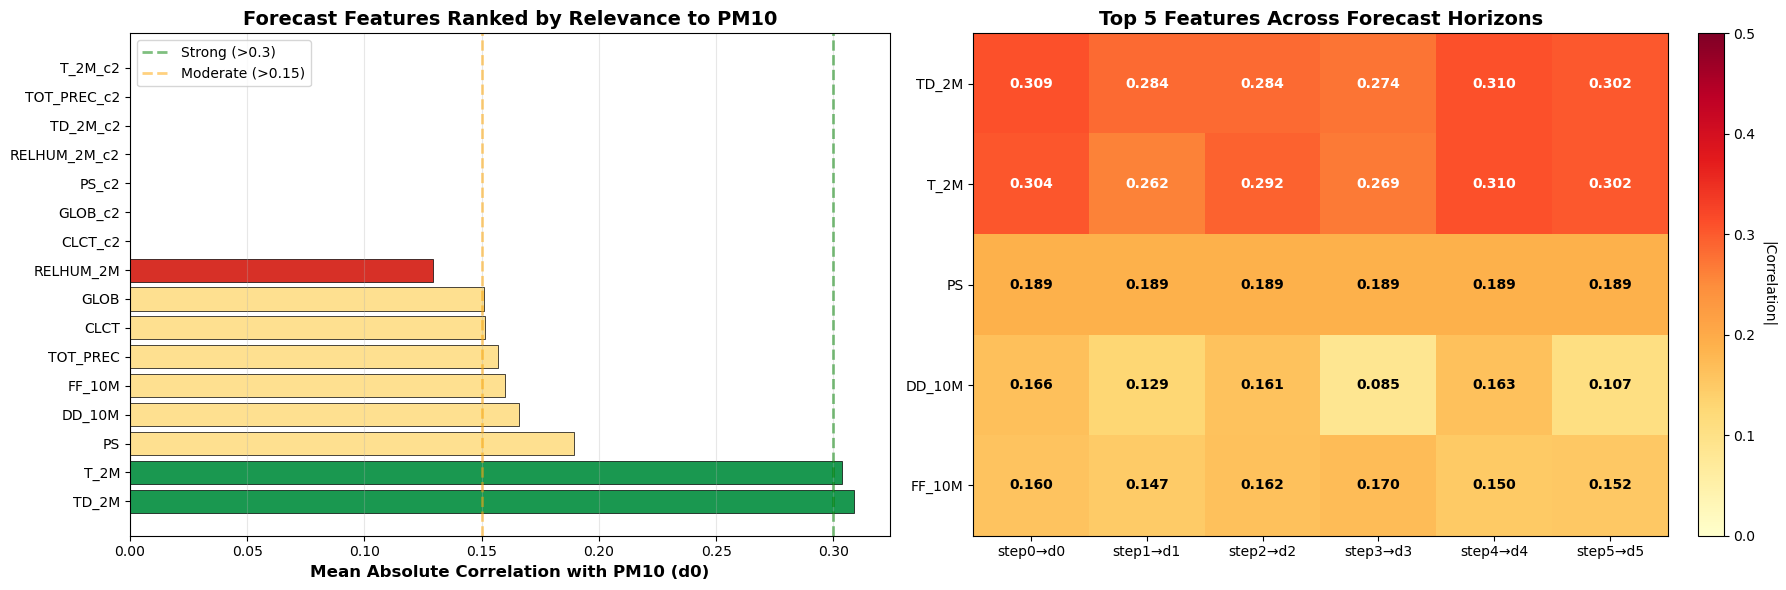


FORECAST FEATURE RANKING (step0→d0 correlation with PM10)
 1. TD_2M           → 0.3088 (STRONG)
 2. T_2M            → 0.3036 (STRONG)
 3. PS              → 0.1893 (MODERATE)
 4. DD_10M          → 0.1657 (MODERATE)
 5. FF_10M          → 0.1599 (MODERATE)
 6. TOT_PREC        → 0.1570 (MODERATE)
 7. CLCT            → 0.1515 (MODERATE)
 8. GLOB            → 0.1512 (MODERATE)
 9. RELHUM_2M       → 0.1291 (WEAK)
10. CLCT_c2         → 0.0000 (WEAK)
11. GLOB_c2         → 0.0000 (WEAK)
12. PS_c2           → 0.0000 (WEAK)
13. RELHUM_2M_c2    → 0.0000 (WEAK)
14. TD_2M_c2        → 0.0000 (WEAK)
15. TOT_PREC_c2     → 0.0000 (WEAK)
16. T_2M_c2         → 0.0000 (WEAK)

KEY INSIGHTS:

✓ Top 5 most predictive forecast features: TD_2M, T_2M, PS, DD_10M, FF_10M
✓ Features with correlation > 0.3 are strongly relevant
✓ Consider feature selection based on these correlations
✓ COSMO-2 (_c2) vs base COSMO comparison available



In [17]:
print("="*80)
print("FORECAST FEATURE CORRELATION ANALYSIS - IDENTIFYING MOST RELEVANT FEATURES")
print("="*80)

# Get all forecast signals
forecast_cols = [col for col in X_train.columns if '__step' in col]
all_forecast_signals = sorted(set([col.split('__')[1] for col in forecast_cols]))

print(f"\nAnalyzing {len(all_forecast_signals)} forecast signals:")
print(all_forecast_signals)

# Calculate correlation for each forecast signal with PM10 targets
# We'll use step0 → d0 (most direct relationship)
forecast_correlations = {}

for feat_signal in all_forecast_signals:
    # Get step0 forecast columns for this signal
    step0_cols = [col for col in X_train.columns if f'__{feat_signal}__step0' in col]
    
    # Get d0 target columns (excluding average)
    d0_target_cols = [col for col in y_train.columns if 'AVG' in col]
    
    if step0_cols and d0_target_cols:
        corrs = []
        for scol in step0_cols:
            for tcol in d0_target_cols:
                corr = X_train[scol].corr(y_train[tcol])
                if not pd.isna(corr):
                    corrs.append(abs(corr))
        
        if corrs:
            forecast_correlations[feat_signal] = np.mean(corrs)
        else:
            forecast_correlations[feat_signal] = 0
    else:
        forecast_correlations[feat_signal] = 0

# Sort by correlation strength
sorted_correlations = dict(sorted(forecast_correlations.items(), key=lambda x: x[1], reverse=True))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart
signals = list(sorted_correlations.keys())
values = list(sorted_correlations.values())
colors = ['#1a9850' if v > 0.3 else '#fee090' if v > 0.15 else '#d73027' for v in values]

ax1.barh(signals, values, color=colors, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Mean Absolute Correlation with PM10 (d0)', fontsize=12, fontweight='bold')
ax1.set_title('Forecast Features Ranked by Relevance to PM10', fontsize=14, fontweight='bold')
ax1.axvline(x=0.3, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Strong (>0.3)')
ax1.axvline(x=0.15, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Moderate (>0.15)')
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Correlation heatmap across all horizons for top features
top_n = 5
top_features = list(sorted_correlations.keys())[:top_n]

corr_matrix = np.zeros((top_n, 6))
for i, feat_signal in enumerate(top_features):
    for j, (step, horizon) in enumerate(zip(['step0', 'step1', 'step2', 'step3', 'step4', 'step5'],
                                             ['d0', 'd1', 'd2', 'd3', 'd4', 'd5'])):
        step_cols = [col for col in X_train.columns if f'__{feat_signal}__{step}' in col]
        target_cols = [col for col in y_train.columns if 'AVG' in col]
        
        if step_cols and target_cols:
            corrs = []
            for scol in step_cols:
                for tcol in target_cols:
                    corr = X_train[scol].corr(y_train[tcol])
                    if not pd.isna(corr):
                        corrs.append(abs(corr))
            if corrs:
                corr_matrix[i, j] = np.mean(corrs)

im = ax2.imshow(corr_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=0.5)
ax2.set_xticks(np.arange(6))
ax2.set_yticks(np.arange(top_n))
ax2.set_xticklabels(['step0→d0', 'step1→d1', 'step2→d2', 'step3→d3', 'step4→d4', 'step5→d5'])
ax2.set_yticklabels(top_features)
ax2.set_title(f'Top {top_n} Features Across Forecast Horizons', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(top_n):
    for j in range(6):
        text = ax2.text(j, i, f'{corr_matrix[i, j]:.3f}',
                       ha="center", va="center",
                       color="white" if corr_matrix[i, j] > 0.25 else "black",
                       fontsize=10, fontweight='bold')

cbar = plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
cbar.set_label('|Correlation|', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("FORECAST FEATURE RANKING (step0→d0 correlation with PM10)")
print("="*80)
for i, (signal, corr) in enumerate(sorted_correlations.items(), 1):
    strength = "STRONG" if corr > 0.3 else "MODERATE" if corr > 0.15 else "WEAK"
    print(f"{i:2d}. {signal:<15} → {corr:.4f} ({strength})")

print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)
print(f"""
✓ Top {top_n} most predictive forecast features: {', '.join(top_features)}
✓ Features with correlation > 0.3 are strongly relevant
✓ Consider feature selection based on these correlations
✓ COSMO-2 (_c2) vs base COSMO comparison available
""")

For the moment we will use only the common features across all the locations to reduce the amount of missing data we have to impute and the complexity of the model. Moreover forecast features are less correlated with the target than the measurements at m0, so we can expect a smaller contribution to the predictive power of the model.

## 1.  Missing values analysis


In [18]:
missing_features_perc = (X_train.isnull().sum() / len(X_train)) * 100
missing_targets_perc = (y_train.isnull().sum() / len(y_train)) * 100
missing_features_perc = missing_features_perc[missing_features_perc > 0].sort_values(ascending=False)
missing_targets_perc = missing_targets_perc[missing_targets_perc > 0].sort_values(ascending=False)


#

# 1. Measurement missingness analysis

In [19]:
measurement_missing = missing_features_perc[missing_features_perc.index.str.contains('__m')]
print(f"Measurement features with missing values: {len(measurement_missing)}")

#top n missing features
n = 30
print(f"Top {n} missing feature columns:")
print(missing_features_perc.head(n))

Measurement features with missing values: 3170
Top 30 missing feature columns:
NA-MAG__PM2.5__m19    6.609308
NA-MAG__PM2.5__m20    6.491983
LUG__PM2.5__m18       6.491983
NA-MAG__PM2.5__m18    6.452874
LUG__PM2.5__m19       6.413766
NA-MAG__PM2.5__m21    6.413766
NA-MAG__PM2.5__m23    6.374658
NA-MAG__PM2.5__m1     6.374658
NA-MAG__PM2.5__m3     6.374658
NA-MAG__PM2.5__m2     6.374658
NA-MAG__PM2.5__m6     6.374658
NA-MAG__PM2.5__m5     6.374658
NA-MAG__PM2.5__m4     6.374658
NA-MAG__PM2.5__m22    6.374658
LUG__PM2.5__m6        6.374658
LUG__PM2.5__m20       6.374658
LUG__PM2.5__m17       6.374658
NA-MAG__PM2.5__m14    6.335549
NA-MAG__PM2.5__m13    6.335549
NA-MAG__PM2.5__m0     6.335549
NA-MAG__PM2.5__m17    6.335549
NA-MAG__PM2.5__m15    6.335549
LUG__PM2.5__m15       6.335549
LUG__PM2.5__m23       6.335549
LUG__PM2.5__m1        6.335549
LUG__PM2.5__m2        6.335549
NA-MAG__PM2.5__m7     6.335549
LUG__PM2.5__m9        6.335549
LUG__PM2.5__m7        6.335549
NA-MAG__PM2.5__m8     

In [20]:
instant_measurement_missing = missing_features_perc[missing_features_perc.index.str.contains('__m0')]
print(f"Instant Measurement features with missing values: {len(instant_measurement_missing)}")
print(instant_measurement_missing.head(10))

Instant Measurement features with missing values: 91
NA-MAG__PM2.5__m0    6.335549
LUG__PM2.5__m0       6.296441
GIU__Tdew__m0        2.111850
GIU__RH__m0          2.111850
GIU__Gl__m0          1.290575
MS-GEN__RH__m0       1.173250
MS-GEN__Tdew__m0     1.173250
MS-GEN__Prec__m0     1.055925
BIO__RH__m0          0.977708
GIU__WSgust__m0      0.938600
dtype: float64


# Forecast features missingness analysis

In [21]:
forecast_missing = missing_features_perc[missing_features_perc.index.str.contains('__step')]
print(f"Forecast features with missing values: {len(forecast_missing)}")
print(forecast_missing.head(10))

Forecast features with missing values: 1848
TIGIU__RELHUM_2M__step6     2.150958
TIGIU__TD_2M__step6         2.150958
TIGIU__TD_2M__step30        2.150958
TIGIU__RELHUM_2M__step30    2.150958
TIGIU__TD_2M__step5         2.111850
TIGIU__TD_2M__step3         2.111850
TIGIU__TD_2M__step2         2.111850
TIGIU__TD_2M__step1         2.111850
TIGIU__RELHUM_2M__step29    2.111850
TIGIU__RELHUM_2M__step27    2.111850
dtype: float64


# Target Missingness analysis

In [22]:
target_missing = missing_targets_perc
print(f"Target columns with missing values: {len(target_missing)}")
print(target_missing.head(10))
# these are going to be recreated using imputed values later

Target columns with missing values: 0
Series([], dtype: float64)


# 1.  Missing values imputation
Potential strategies for missing value imputation include:
- Simple methods: mean, median, mode imputation
- Advanced methods: KNN imputation, MICE, Time series specific methods (e.g., forward fill, interpolation)

If we want to use forward fill or interpolation, we need to ensure that there are no large gaps in the time index.

In [23]:
#checks for gaps in time index
time_diffs = df.index.to_series().diff().dropna()
gap_threshold = pd.Timedelta(hours=24) #we check for daily gaps since data is daily
gaps = time_diffs[time_diffs > gap_threshold]
if not gaps.empty:
    print("Gaps detected in time index:")
    print(gaps)
else:
    print("No gaps detected in time index.")


No gaps detected in time index.


We will focus on imputing common features across all locations to maintain consistency and reduce complexity in the imputation process.

In [24]:

#check the amount of consecutive missing values per column
#only for the m0 features not considering the forecasts
# 
def max_consecutive_nans(series):
    return series.isnull().astype(int).groupby(series.notnull().astype(int).cumsum()).sum().max()
#look only the common features across all stations
consecutive_nans_measurements = X_train[[f"{loc}__{feat}__m0" for feat in common_features for loc in locations]].apply(max_consecutive_nans)
consecutive_nans_forecasts = X_train[[col for col in features_cols if '__step' in col]].apply(max_consecutive_nans)
consecutive_nans_targets = y_train.apply(max_consecutive_nans)

print("Top 10 measurement features with highest consecutive missing values:")
print(consecutive_nans_measurements.sort_values(ascending=False).head(10))
print("Top 10 forecast features with highest consecutive missing values:")
print(consecutive_nans_forecasts.sort_values(ascending=False).head(10))
print("Top 10 target features with highest consecutive missing values:")
print(consecutive_nans_targets.sort_values(ascending=False).head(10))

Top 10 measurement features with highest consecutive missing values:
GIU__O3__m0        10
NA-MAG__NO2__m0     3
LUG__NOx__m0        3
LUG__NO2__m0        3
NA-MAG__NO__m0      3
LUG__O3__m0         3
BIO__O3__m0         3
LUG__NO__m0         3
NA-MAG__NOx__m0     3
LOC__O3__m0         2
dtype: int64
Top 10 forecast features with highest consecutive missing values:
TIGIU__RELHUM_2M_c2__step81    46
TIGIU__RELHUM_2M__step25       46
TIGIU__RELHUM_2M__step26       46
TIGIU__RELHUM_2M__step27       46
TIGIU__TD_2M__step7            46
TIGIU__TD_2M__step6            46
TIGIU__TD_2M__step5            46
TIGIU__RELHUM_2M__step28       46
TIGIU__RELHUM_2M__step29       46
TIGIU__TD_2M__step4            46
dtype: int64
Top 10 target features with highest consecutive missing values:
AVG__YPM10-dailymean__d0    0
AVG__YPM10-dailymean__d1    0
AVG__YPM10-dailymean__d2    0
AVG__YPM10-dailymean__d3    0
AVG__YPM10-dailymean__d4    0
AVG__YPM10-dailymean__d5    0
dtype: int64


We will use spatial imputation by grouping by similar location and imputing missing values.

In [25]:
print(common_features)

{'PM10_lag1', 'O3', 'NO', 'NO2', 'NOx'}


In [26]:
X_train.columns

Index(['BIO__NO__m0', 'BIO__NO__m1', 'BIO__NO__m2', 'BIO__NO__m3',
       'BIO__NO__m4', 'BIO__NO__m5', 'BIO__NO__m6', 'BIO__NO__m7',
       'BIO__NO__m8', 'BIO__NO__m9',
       ...
       'TIGIU__TD_2M_c2__step117', 'TIGIU__TD_2M_c2__step120',
       'BIO__PM10_lag1__m0', 'CHI__PM10_lag1__m0', 'LUG__PM10_lag1__m0',
       'MEN__PM10_lag1__m0', 'BRI__PM10_lag1__m0', 'GIU__PM10_lag1__m0',
       'LOC__PM10_lag1__m0', 'NA-MAG__PM10_lag1__m0'],
      dtype='object', length=8304)

LOCATION GROUPING - HIERARCHICAL CLUSTERING APPROACH
Analyzing 5 common features: ['NO', 'NO2', 'NOx', 'O3', 'PM10_lag1']


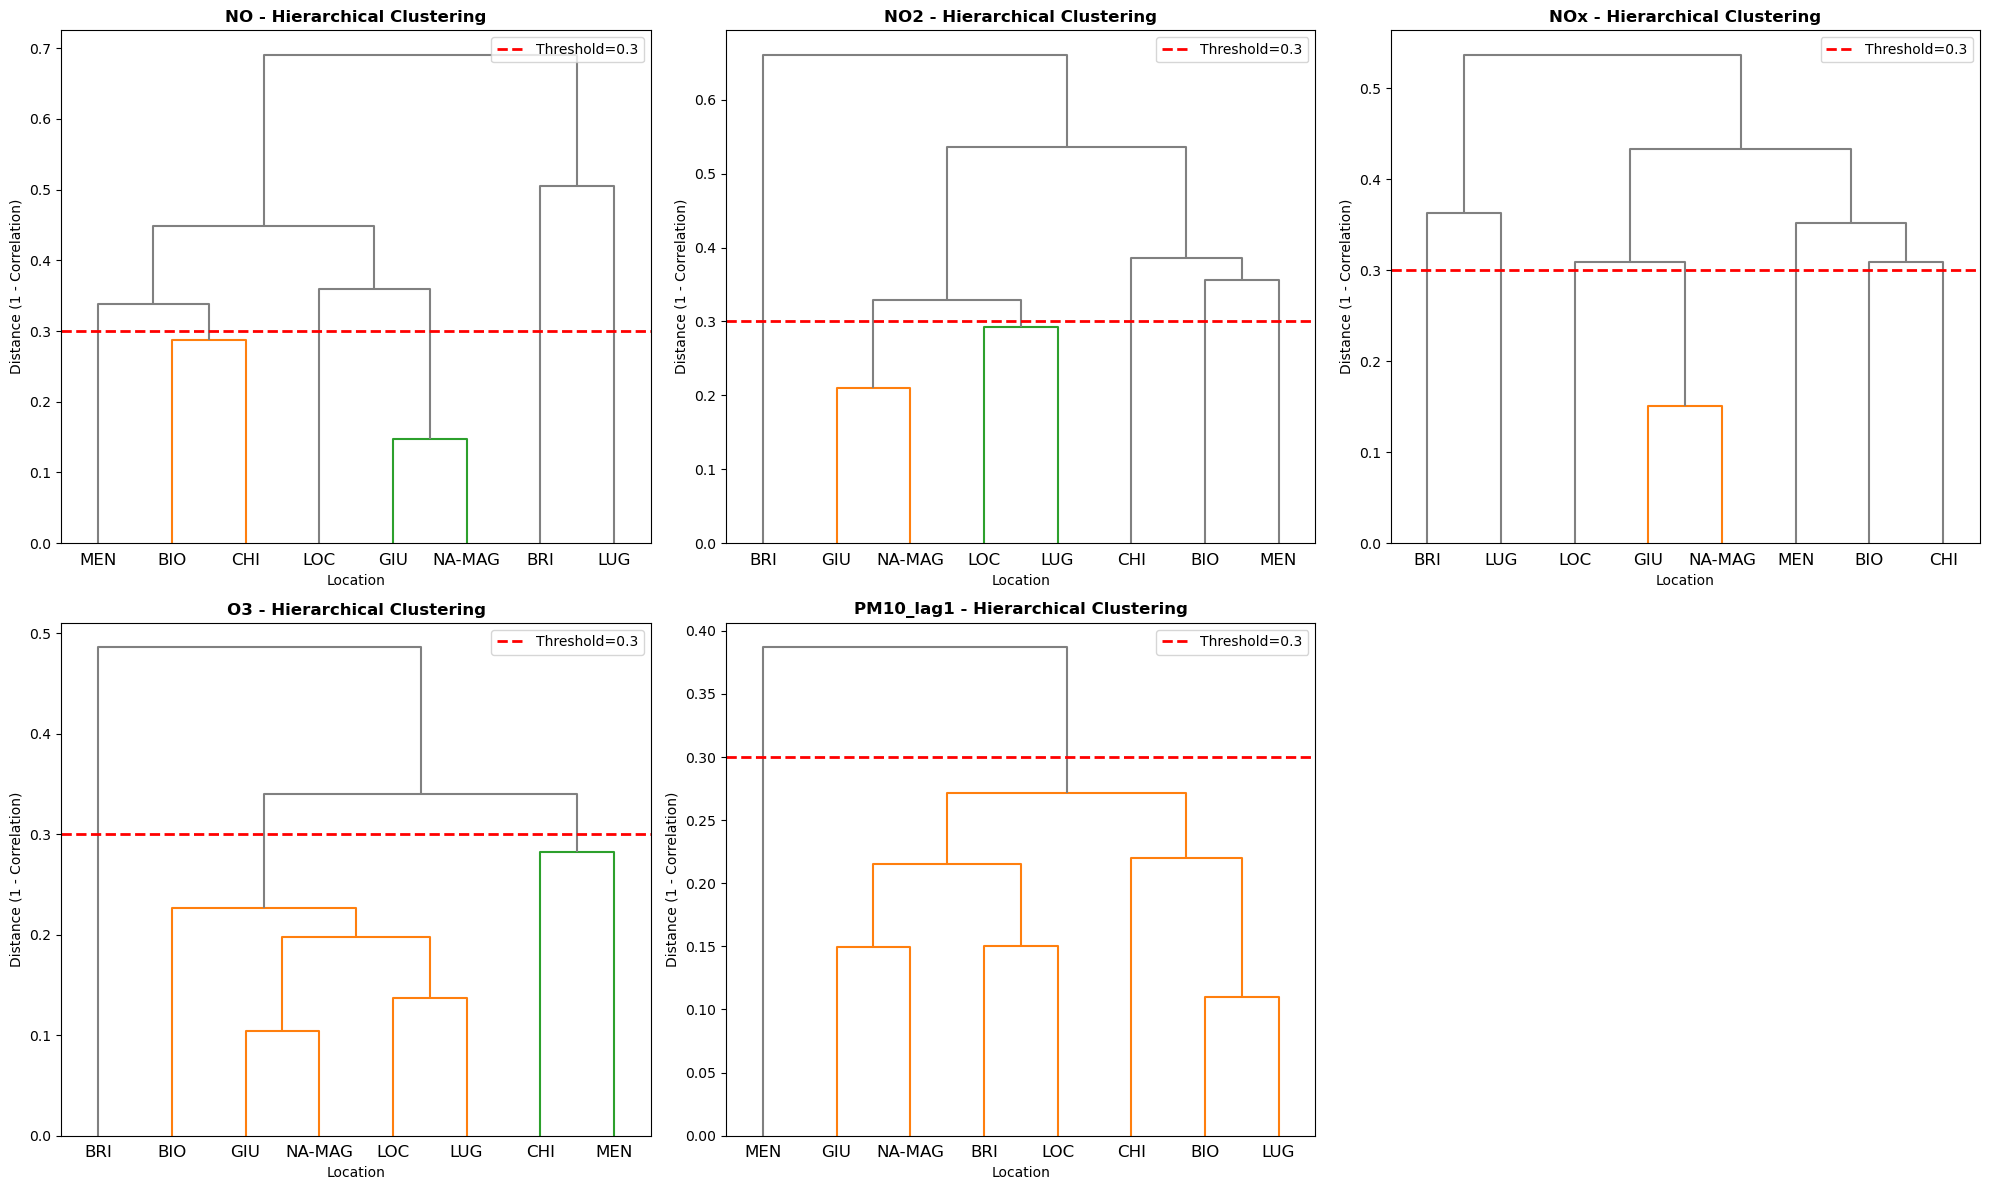

IDENTIFIED CLUSTERS (threshold = 0.3):

NO:
  Cluster 1: ['BIO', 'CHI']
  Cluster 2: ['MEN']
  Cluster 3: ['GIU', 'NA-MAG']
  Cluster 4: ['LOC']
  Cluster 5: ['BRI']
  Cluster 6: ['LUG']

NO2:
  Cluster 1: ['GIU', 'NA-MAG']
  Cluster 2: ['LOC', 'LUG']
  Cluster 3: ['BIO']
  Cluster 4: ['MEN']
  Cluster 5: ['CHI']
  Cluster 6: ['BRI']

NOx:
  Cluster 1: ['BRI']
  Cluster 2: ['LUG']
  Cluster 3: ['GIU', 'NA-MAG']
  Cluster 4: ['LOC']
  Cluster 5: ['BIO']
  Cluster 6: ['CHI']
  Cluster 7: ['MEN']

O3:
  Cluster 1: ['BIO', 'GIU', 'LOC', 'LUG', 'NA-MAG']
  Cluster 2: ['CHI', 'MEN']
  Cluster 3: ['BRI']

PM10_lag1:
  Cluster 1: ['BIO', 'BRI', 'CHI', 'GIU', 'LOC', 'LUG', 'NA-MAG']
  Cluster 2: ['MEN']
CONSENSUS ANALYSIS ACROSS FEATURES:

Location pairs co-occurring in same cluster:
  GIU-NA-MAG: 5/5 features
  LOC-LUG: 3/5 features
  BIO-CHI: 2/5 features
  BIO-GIU: 2/5 features
  BIO-LOC: 2/5 features
  BIO-LUG: 2/5 features
  BIO-NA-MAG: 2/5 features
  GIU-LOC: 2/5 features
  GIU-LUG: 2/5 f

In [27]:
# Justify location grouping using hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from collections import defaultdict

print("LOCATION GROUPING - HIERARCHICAL CLUSTERING APPROACH")

# Use all common features for clustering analysis
features_to_analyze = sorted(list(common_features))
print(f"Analyzing {len(features_to_analyze)} common features: {features_to_analyze}")

# Calculate grid size for subplots
n_features = len(features_to_analyze)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

# Store cluster assignments for each feature
all_cluster_assignments = {}

for idx, feat in enumerate(features_to_analyze):
    ax = axes[idx]
    
    # Get columns for this feature across all locations
    feat_cols = [f"{loc}__{feat}__m0" for loc in locations if f"{loc}__{feat}__m0" in X_train.columns]
    
    if not feat_cols:
        ax.set_visible(False)
        continue
    
    # Calculate correlation matrix
    corr_matrix = X_train[feat_cols].corr()
    
    # Convert correlation to distance (1 - correlation) because linkage expects a distance matrix
    distance_matrix = 1 - corr_matrix
    condensed_dist = squareform(distance_matrix)
    
    # Perform hierarchical clustering
    linkage_matrix = linkage(condensed_dist, method='average')
    
    # Create dendrogram
    loc_labels = [col.split('__')[0] for col in feat_cols]
    dendrogram(linkage_matrix, labels=loc_labels, ax=ax, 
               color_threshold=0.3, above_threshold_color='gray')
    
    ax.set_title(f'{feat} - Hierarchical Clustering', fontsize=12, fontweight='bold')
    ax.set_xlabel('Location', fontsize=10)
    ax.set_ylabel('Distance (1 - Correlation)', fontsize=10)
    ax.axhline(y=0.3, color='red', linestyle='--', linewidth=2, label='Threshold=0.3')
    ax.legend()
    
    # Extract clusters for this feature
    threshold = 0.3
    clusters = fcluster(linkage_matrix, threshold, criterion='distance')
    all_cluster_assignments[feat] = dict(zip(loc_labels, clusters))

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# Print identified clusters per feature
print("IDENTIFIED CLUSTERS (threshold = 0.3):")

for feat in features_to_analyze:
    if feat not in all_cluster_assignments:
        continue
    
    print(f"\n{feat}:")
    cluster_dict = {}
    for loc, cluster_id in all_cluster_assignments[feat].items():
        if cluster_id not in cluster_dict:
            cluster_dict[cluster_id] = []
        cluster_dict[cluster_id].append(loc)
    
    for cluster_id, locs in sorted(cluster_dict.items()):
        print(f"  Cluster {cluster_id}: {locs}")

# Find consensus grouping: count how often each pair co-occurs
print("CONSENSUS ANALYSIS ACROSS FEATURES:")

# Initialize pair counts such that we can count co-occurrences
location_pairs = {}
for loc1 in locations:
    for loc2 in locations:
        if loc1 < loc2:
            location_pairs[(loc1, loc2)] = 0

# Count co-occurrences
# For each feature, for each cluster, increment pair counts
# if two locations are in the same cluster for a feature, increment their pair count
for feat, assignments in all_cluster_assignments.items():
    cluster_dict = {}
    for loc, cluster_id in assignments.items():
        if cluster_id not in cluster_dict:
            cluster_dict[cluster_id] = []
        cluster_dict[cluster_id].append(loc)
    
    for locs in cluster_dict.values():
        for i, loc1 in enumerate(locs):
            for loc2 in locs[i+1:]:
                pair = tuple(sorted([loc1, loc2]))
                if pair in location_pairs:
                    location_pairs[pair] += 1

# Show pairs that cluster together consistently
print("\nLocation pairs co-occurring in same cluster:")
for pair, count in sorted(location_pairs.items(), key=lambda x: x[1], reverse=True):
    if count > 0:
        print(f"  {pair[0]}-{pair[1]}: {count}/{len(features_to_analyze)} features")

# Derive final groups from consensus
# Use locations that consistently cluster together (2+ features, or 50% of features)
from collections import defaultdict
location_graph = defaultdict(set)

min_cooccurrence = max(2, len(features_to_analyze) // 2)  # At least 2 or 50% of features
print(f"\nUsing minimum co-occurrence threshold: {min_cooccurrence} features")

for (loc1, loc2), count in location_pairs.items():
    if count >= min_cooccurrence:
        location_graph[loc1].add(loc2)
        location_graph[loc2].add(loc1)

# Find connected components (groups)
# we use connected components in the location graph
# because locations that cluster together form a group
visited = set()
final_groups = []

def dfs(loc, group):
    visited.add(loc)
    group.add(loc)
    for neighbor in location_graph[loc]:
        if neighbor not in visited:
            dfs(neighbor, group)

for loc in locations:
    if loc not in visited:
        group = set()
        dfs(loc, group)
        if group:
            final_groups.append(sorted(group))

print("FINAL PROPOSED GROUPING (derived from clustering):")
for i, group in enumerate(final_groups, 1):
    print(f"  Group {i}: {group}")

# Save for later use
location_groups = {f'group{i+1}': group for i, group in enumerate(final_groups)}

Validating grouping with 5 common features


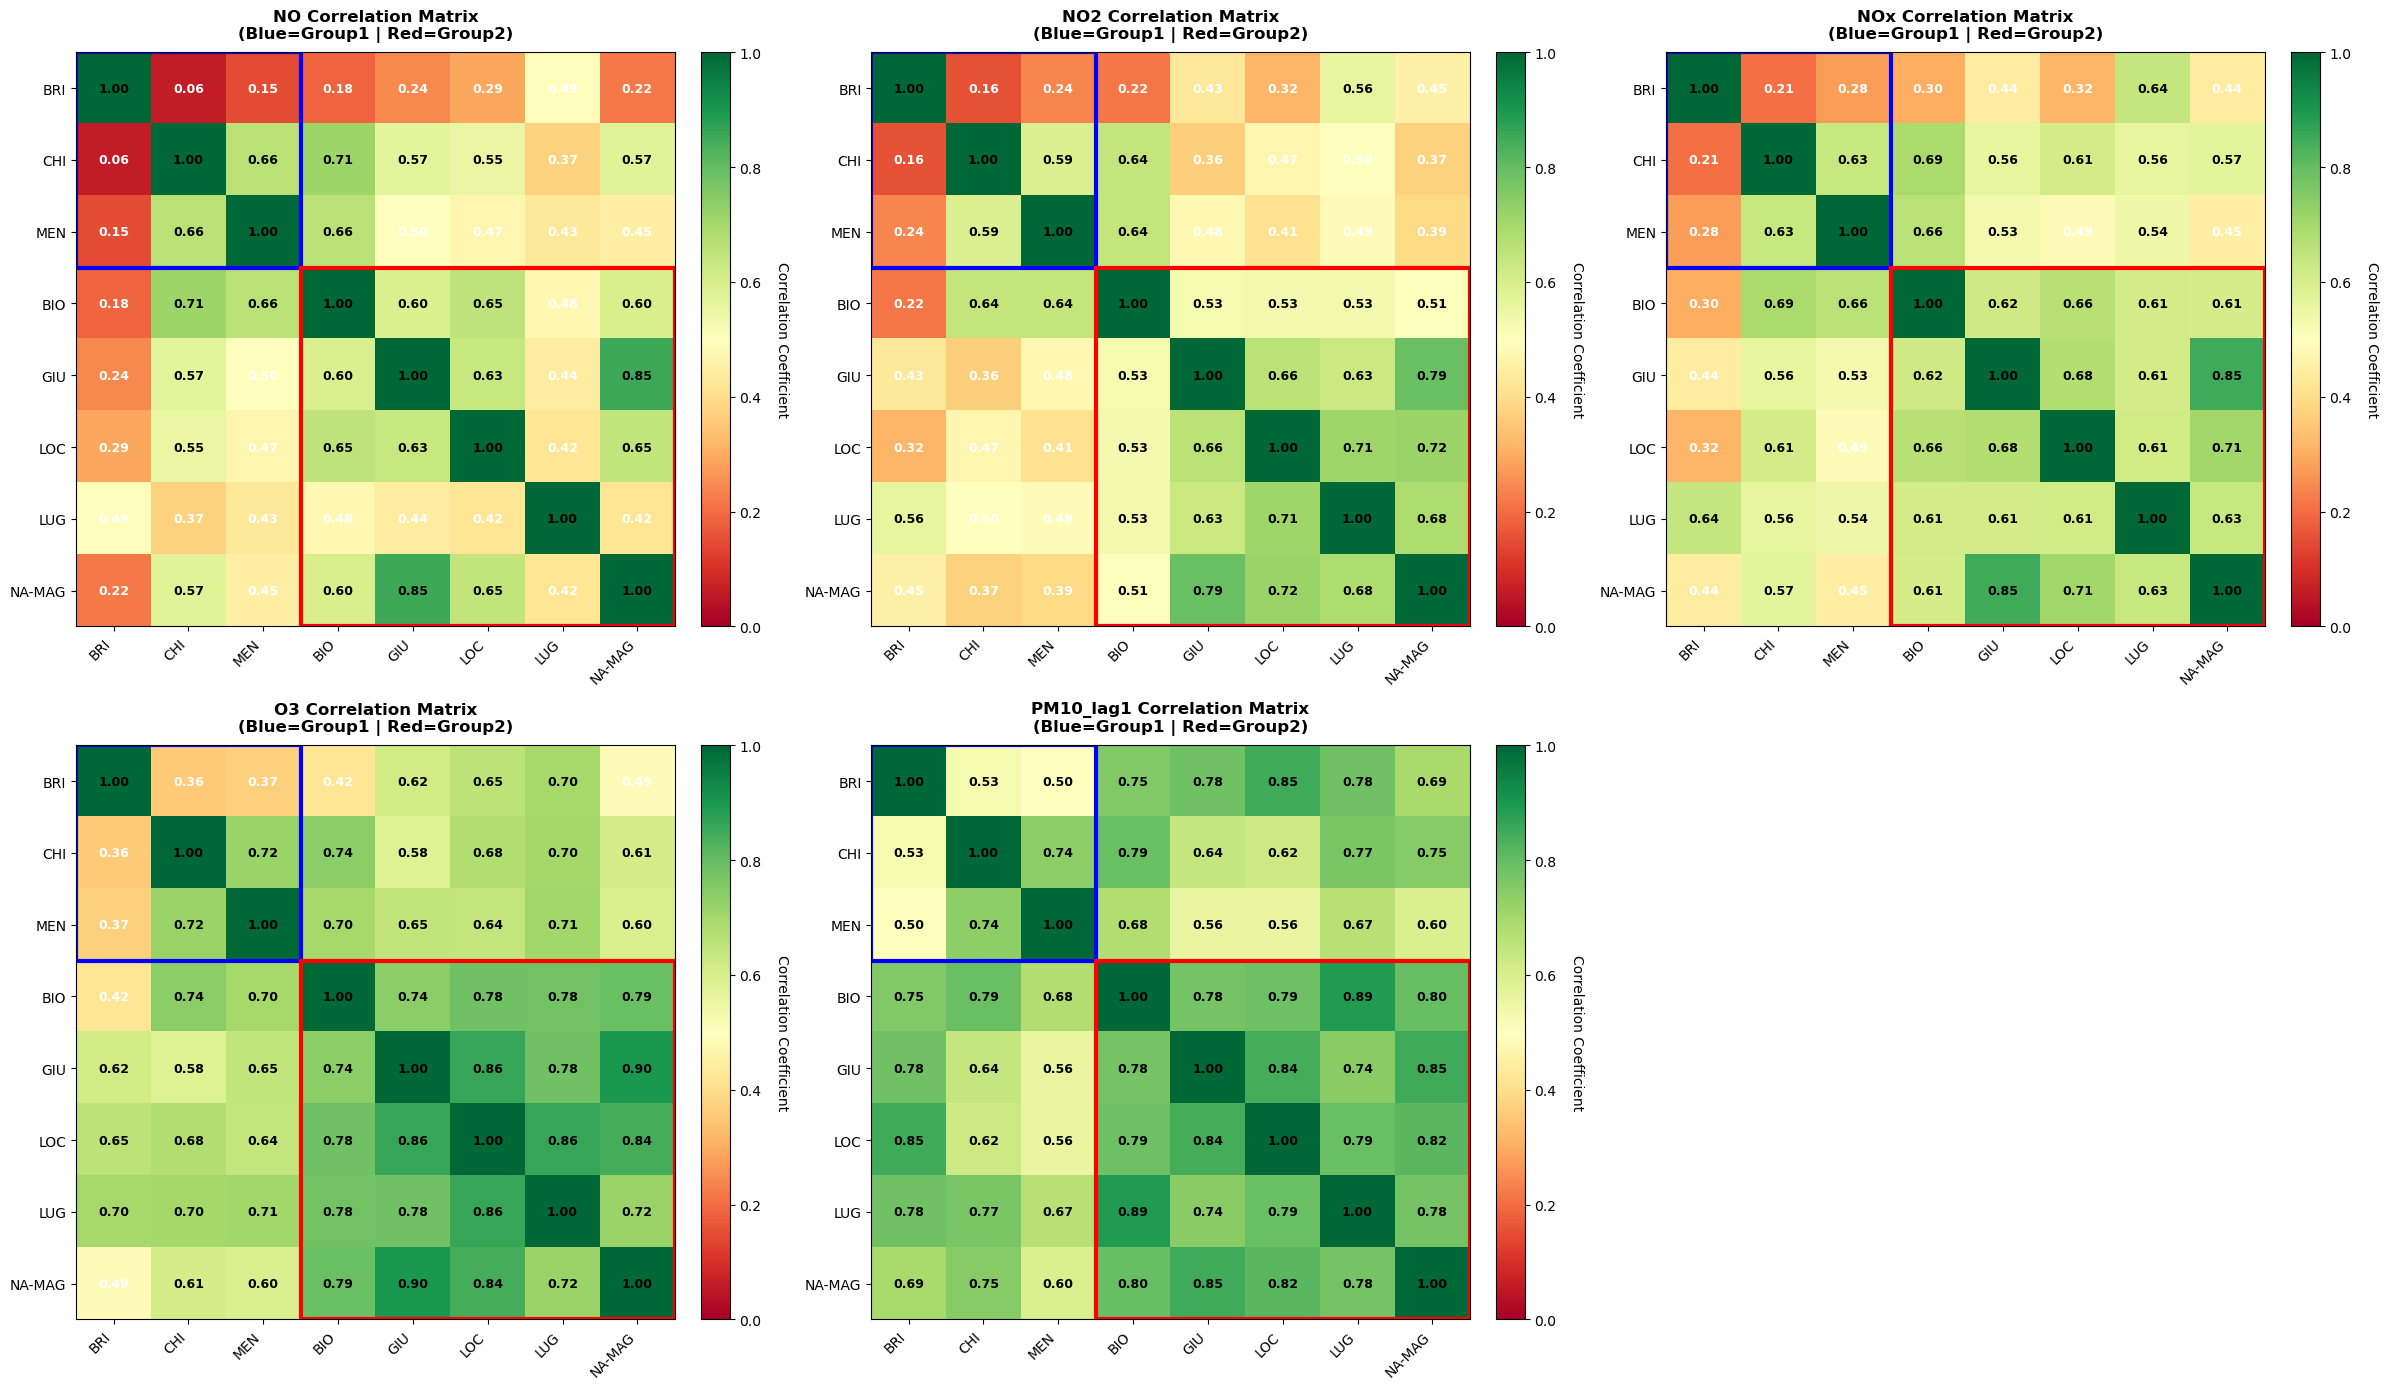

In [28]:
# Verify grouping with heatmaps showing correlation within/across groups
from matplotlib.patches import Rectangle

# Use the groups derived from clustering (or define manually if needed)
# Note: location_groups should already be defined from the previous cell
# If not, uncomment the following:
location_groups = {
    'group1': ['BRI', 'CHI', 'MEN'],
    'group2': ['BIO', 'GIU', 'LOC', 'LUG', 'NA-MAG']
}

# Create heatmaps for all common features
features_for_validation = sorted(list(common_features))
print(f"Validating grouping with {len(features_for_validation)} common features")

# Calculate grid size for subplots
n_features = len(features_for_validation)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 7 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

for idx, feat in enumerate(features_for_validation):
    ax = axes[idx]
    
    # Get feature columns for all locations
    feat_cols = [f"{loc}__{feat}__m0" for loc in locations if f"{loc}__{feat}__m0" in X_train.columns]
    
    if not feat_cols:
        ax.set_visible(False)
        continue
    
    # Calculate correlation matrix
    corr_matrix = X_train[feat_cols].corr()
    
    # Reorder to group locations together
    ordered_locs = location_groups['group1'] + location_groups['group2']
    ordered_cols = [f"{loc}__{feat}__m0" for loc in ordered_locs if f"{loc}__{feat}__m0" in feat_cols]
    corr_matrix = corr_matrix.loc[ordered_cols, ordered_cols]
    
    # Create heatmap
    im = ax.imshow(corr_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    
    # Set ticks
    loc_labels = [col.split('__')[0] for col in ordered_cols]
    ax.set_xticks(np.arange(len(ordered_cols)))
    ax.set_yticks(np.arange(len(ordered_cols)))
    ax.set_xticklabels(loc_labels, fontsize=10, rotation=45, ha='right')
    ax.set_yticklabels(loc_labels, fontsize=10)
    
    # Add text annotations
    for i in range(len(ordered_cols)):
        for j in range(len(ordered_cols)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha="center", va="center", 
                          color="white" if corr_matrix.iloc[i, j] < 0.5 else "black",
                          fontsize=9, fontweight='bold')
    
    # Draw rectangles around groups
    n_group1 = len([loc for loc in location_groups['group1'] if f"{loc}__{feat}__m0" in feat_cols])
    
    # Group 1 rectangle (top-left)
    rect1 = Rectangle((-0.5, -0.5), n_group1, n_group1, 
                      linewidth=3, edgecolor='blue', facecolor='none', label='Group 1')
    ax.add_patch(rect1)
    
    # Group 2 rectangle (bottom-right)
    rect2 = Rectangle((n_group1-0.5, n_group1-0.5), 
                      len(ordered_cols)-n_group1, len(ordered_cols)-n_group1,
                      linewidth=3, edgecolor='red', facecolor='none', label='Group 2')
    ax.add_patch(rect2)
    
    ax.set_title(f'{feat} Correlation Matrix\n(Blue=Group1 | Red=Group2)', 
                 fontsize=12, fontweight='bold', pad=10)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()




In [29]:
# Create copies to avoid modifying original data
X_train_imputed = X_train.copy()
y_train_imputed = y_train.copy()


In [30]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# At the top of the imputation cell
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [31]:
# Step 1: Impute common features (m0) using spatial grouping with daily mean
print("IMPUTING COMMON FEATURES (m0) WITH SPATIAL GROUPING - DAILY MEAN APPROACH")
print("="*80)

for feat in sorted(common_features):
    print(f"\nProcessing {feat}...")
    
    for group_name, group_locs in location_groups.items():
        # Get columns for this feature and group
        group_cols = [f"{loc}__{feat}__m0" for loc in group_locs 
                     if f"{loc}__{feat}__m0" in X_train_imputed.columns]
        
        if not group_cols:
            continue
        
        # Count missing values before imputation
        missing_before = X_train_imputed[group_cols].isnull().sum().sum()
        
        if missing_before == 0:
            print(f"  {group_name}: No missing values")
            continue
        
        print(f"  {group_name}: {missing_before} missing values to impute")
        
        # For each day, calculate mean across available stations in the group
        # and use it to fill missing values
        for col in group_cols:
            # Get the column data
            col_data = X_train_imputed[col].copy()
            
            # Find rows where this column is missing
            missing_mask = col_data.isnull()
            
            if not missing_mask.any():
                continue
            
            # For each missing value, calculate mean of other stations on that day
            for idx in col_data[missing_mask].index:
                # Get values from all other stations in the group on this day
                other_cols = [c for c in group_cols if c != col]
                day_values = X_train_imputed.loc[idx, other_cols]
                
                # Calculate mean (ignoring NaNs)
                if day_values.notna().any():
                    col_data.loc[idx] = day_values.mean()
            
            # Update the column
            X_train_imputed[col] = col_data
        
        # Forward fill any remaining missing values (when all stations are missing)
        X_train_imputed[group_cols] = X_train_imputed[group_cols].ffill()
        
        # Backward fill at the start if needed
        X_train_imputed[group_cols] = X_train_imputed[group_cols].bfill()
        
        missing_after = X_train_imputed[group_cols].isnull().sum().sum()
        print(f"  {group_name}: {missing_after} missing values remaining after imputation")


IMPUTING COMMON FEATURES (m0) WITH SPATIAL GROUPING - DAILY MEAN APPROACH

Processing NO...
  group1: 12 missing values to impute
  group1: 0 missing values remaining after imputation
  group2: 19 missing values to impute
  group2: 0 missing values remaining after imputation

Processing NO2...
  group1: 12 missing values to impute
  group1: 0 missing values remaining after imputation
  group2: 19 missing values to impute
  group2: 0 missing values remaining after imputation

Processing NOx...
  group1: 12 missing values to impute
  group1: 0 missing values remaining after imputation
  group2: 19 missing values to impute
  group2: 0 missing values remaining after imputation

Processing O3...
  group1: 10 missing values to impute
  group1: 0 missing values remaining after imputation
  group2: 36 missing values to impute
  group2: 0 missing values remaining after imputation

Processing PM10_lag1...
  group1: No missing values
  group2: No missing values


In [32]:
# Check ONLY common m0 features after imputation
print("CHECKING COMMON M0 FEATURES AFTER IMPUTATION")

# Only get m0 columns for COMMON features
common_m0_cols = [f"{loc}__{feat}__m0" for feat in common_features for loc in locations 
                  if f"{loc}__{feat}__m0" in X_train_imputed.columns]

missing_m0 = X_train_imputed[common_m0_cols].isnull().sum().sum()

print(f"\nCommon features: {sorted(common_features)}")
print(f"Total common m0 columns: {len(common_m0_cols)}")
print(f"Missing values in COMMON m0 features: {missing_m0}")

CHECKING COMMON M0 FEATURES AFTER IMPUTATION

Common features: ['NO', 'NO2', 'NOx', 'O3', 'PM10_lag1']
Total common m0 columns: 40
Missing values in COMMON m0 features: 0


## 1. Outlier Detection Analysis

We'll detect outliers using multiple aggregation strategies:
1. **IQR method** within each group
2. **Z-score method** across all stations
3. **Group comparison** to detect systematic differences between groups

In [33]:
from scipy import stats

def detect_outliers_iqr(data, multiplier=1.5):
    """Detect outliers using IQR method"""
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers, lower_bound, upper_bound

def detect_outliers_zscore(data, threshold=3):
    """Detect outliers using Z-score method"""
    z_scores = np.abs(stats.zscore(data.dropna()))
    outliers = pd.Series(False, index=data.index)
    outliers.loc[data.dropna().index] = z_scores > threshold
    return outliers, threshold


# Store outlier statistics
outlier_stats = {
    'feature': [],
    'location': [],
    'group': [],
    'n_outliers_iqr': [],
    'pct_outliers_iqr': [],
    'n_outliers_zscore': [],
    'pct_outliers_zscore': []
}

for feat in sorted(common_features):
    
    for group_name, group_locs in location_groups.items():
        
        for loc in group_locs:
            col_name = f"{loc}__{feat}__m0"
            
            if col_name not in X_train_imputed.columns:
                continue
            
            data = X_train_imputed[col_name]
            
            # IQR method
            outliers_iqr, lower_iqr, upper_iqr = detect_outliers_iqr(data)
            n_outliers_iqr = outliers_iqr.sum()
            pct_outliers_iqr = (n_outliers_iqr / len(data)) * 100
            
            # Z-score method
            outliers_zscore, threshold = detect_outliers_zscore(data)
            n_outliers_zscore = outliers_zscore.sum()
            pct_outliers_zscore = (n_outliers_zscore / len(data)) * 100
            
            # Store statistics
            outlier_stats['feature'].append(feat)
            outlier_stats['location'].append(loc)
            outlier_stats['group'].append(group_name)
            outlier_stats['n_outliers_iqr'].append(n_outliers_iqr)
            outlier_stats['pct_outliers_iqr'].append(pct_outliers_iqr)
            outlier_stats['n_outliers_zscore'].append(n_outliers_zscore)
            outlier_stats['pct_outliers_zscore'].append(pct_outliers_zscore)
            

# Convert to DataFrame for easier analysis
outlier_df = pd.DataFrame(outlier_stats)


# Group-level aggregation
group_summary = outlier_df.groupby(['feature', 'group']).agg({
    'n_outliers_iqr': 'sum',
    'pct_outliers_iqr': 'mean',
    'n_outliers_zscore': 'sum',
    'pct_outliers_zscore': 'mean'
}).round(2)


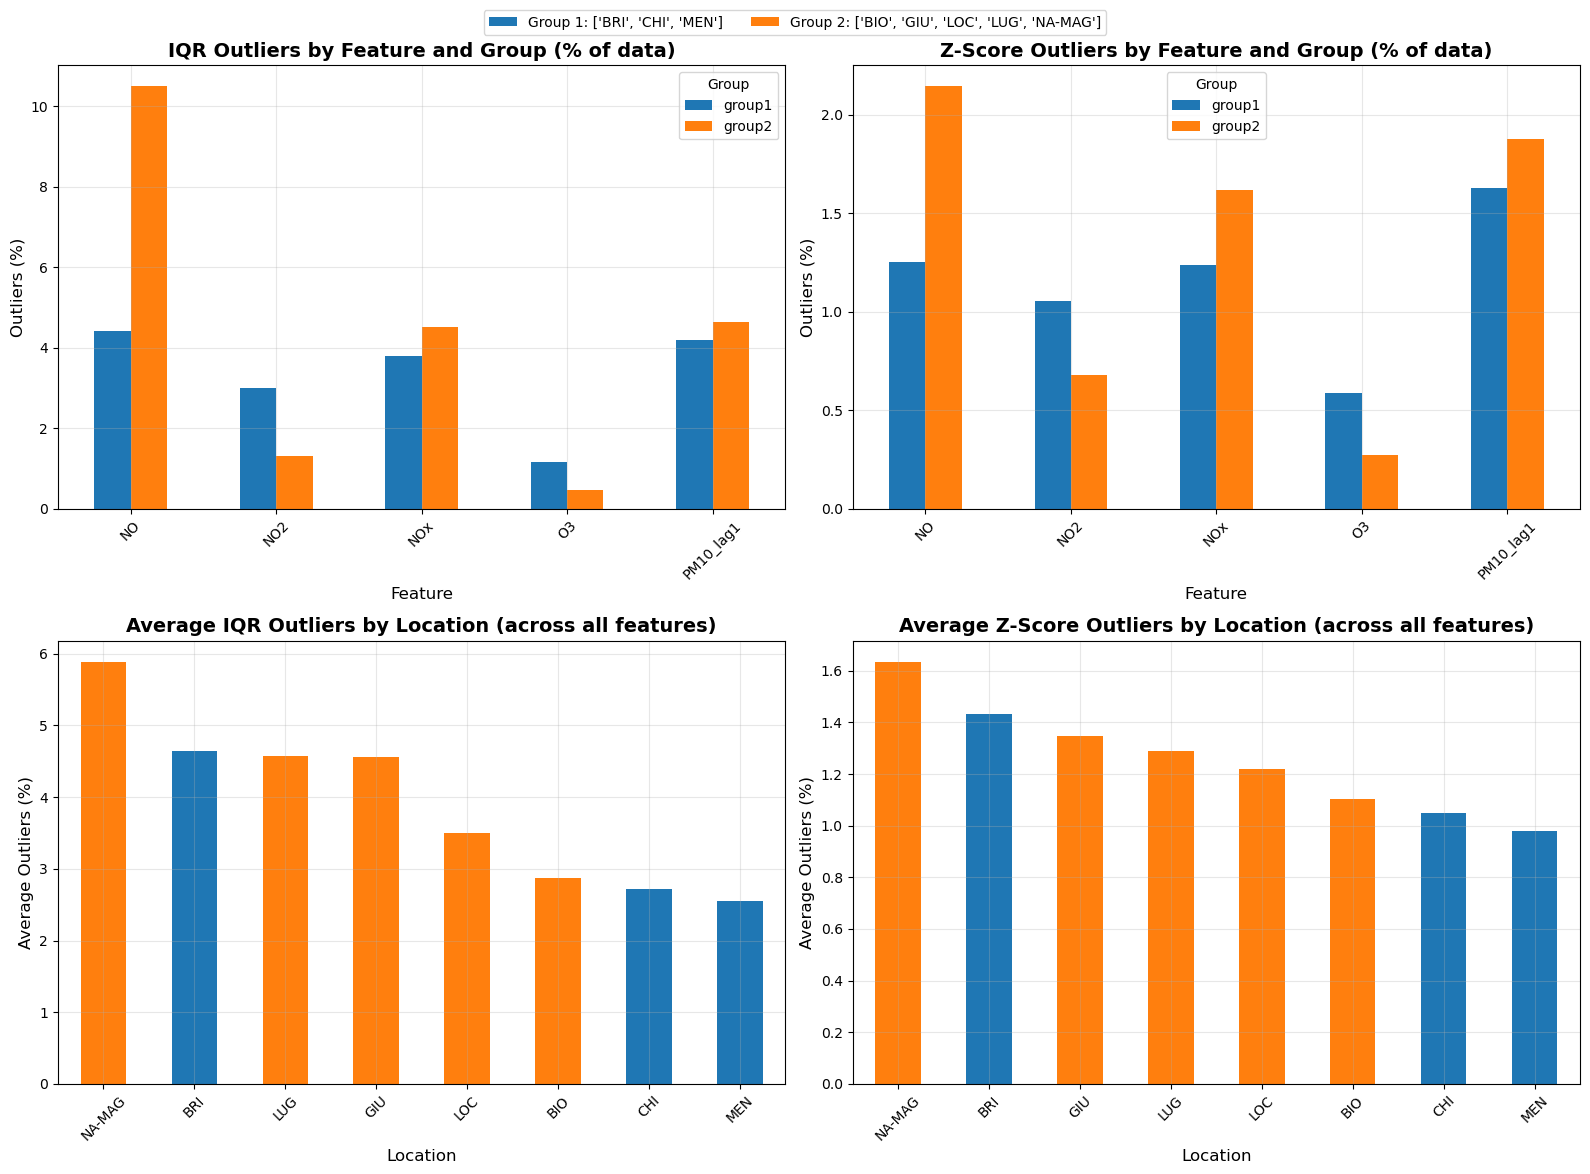


KEY FINDINGS:
1. Locations with most outliers (IQR): {'NA-MAG': 5.8897145091904575, 'BRI': 4.638247946812671, 'LUG': 4.567852952678921}
2. Locations with most outliers (Z-score): {'NA-MAG': 1.6347281971059835, 'BRI': 1.4313648807195931, 'GIU': 1.3453265545561204}
3. Features with most outliers:
   NO: 8.21%
   NO2: 1.94%
   NOx: 4.24%
   O3: 0.72%
   PM10_lag1: 4.47%


In [34]:
# Visualize outlier percentages by feature and group
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# IQR outliers by feature and group
ax1 = axes[0, 0]
pivot_iqr = outlier_df.pivot_table(
    values='pct_outliers_iqr', 
    index='feature', 
    columns='group', 
    aggfunc='mean'
)
pivot_iqr.plot(kind='bar', ax=ax1, color=['#1f77b4', '#ff7f0e'])
ax1.set_title('IQR Outliers by Feature and Group (% of data)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Outliers (%)', fontsize=12)
ax1.set_xlabel('Feature', fontsize=12)
ax1.legend(title='Group', fontsize=10)
ax1.grid(alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Z-score outliers by feature and group
ax2 = axes[0, 1]
pivot_zscore = outlier_df.pivot_table(
    values='pct_outliers_zscore', 
    index='feature', 
    columns='group', 
    aggfunc='mean'
)
pivot_zscore.plot(kind='bar', ax=ax2, color=['#1f77b4', '#ff7f0e'])
ax2.set_title('Z-Score Outliers by Feature and Group (% of data)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Outliers (%)', fontsize=12)
ax2.set_xlabel('Feature', fontsize=12)
ax2.legend(title='Group', fontsize=10)
ax2.grid(alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# IQR outliers by location
ax3 = axes[1, 0]
outlier_by_loc_iqr = outlier_df.groupby('location')['pct_outliers_iqr'].mean().sort_values(ascending=False)
colors_loc = ['#1f77b4' if loc in location_groups['group1'] else '#ff7f0e' 
              for loc in outlier_by_loc_iqr.index]
outlier_by_loc_iqr.plot(kind='bar', ax=ax3, color=colors_loc)
ax3.set_title('Average IQR Outliers by Location (across all features)', 
              fontsize=14, fontweight='bold')
ax3.set_ylabel('Average Outliers (%)', fontsize=12)
ax3.set_xlabel('Location', fontsize=12)
ax3.grid(alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Z-score outliers by location
ax4 = axes[1, 1]
outlier_by_loc_zscore = outlier_df.groupby('location')['pct_outliers_zscore'].mean().sort_values(ascending=False)
colors_loc = ['#1f77b4' if loc in location_groups['group1'] else '#ff7f0e' 
              for loc in outlier_by_loc_zscore.index]
outlier_by_loc_zscore.plot(kind='bar', ax=ax4, color=colors_loc)
ax4.set_title('Average Z-Score Outliers by Location (across all features)', 
              fontsize=14, fontweight='bold')
ax4.set_ylabel('Average Outliers (%)', fontsize=12)
ax4.set_xlabel('Location', fontsize=12)
ax4.grid(alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Add legend for group colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', label=f"Group 1: {location_groups['group1']}"),
    Patch(facecolor='#ff7f0e', label=f"Group 2: {location_groups['group2']}")
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
           ncol=2, fontsize=10, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n" + "="*80)
print("KEY FINDINGS:")
print("="*80)
print(f"1. Locations with most outliers (IQR): {outlier_by_loc_iqr.head(3).to_dict()}")
print(f"2. Locations with most outliers (Z-score): {outlier_by_loc_zscore.head(3).to_dict()}")
print(f"3. Features with most outliers:")
for feat in sorted(common_features):
    feat_outliers = outlier_df[outlier_df['feature'] == feat]['pct_outliers_iqr'].mean()
    print(f"   {feat}: {feat_outliers:.2f}%")

In [35]:
# Define columns to KEEP: only common features at m0 (NO FORECASTS)
cols_to_keep = [f"{loc}__{feat}__m0" for feat in common_features for loc in locations 
                if f"{loc}__{feat}__m0" in X_train_imputed.columns]

# Drop everything else (forecasts, lags, non-common features)
X_train_imputed = X_train_imputed[cols_to_keep]

# Display kept features
print(f"\nKept features: {sorted(common_features)}")
print(f"Locations: {locations}")
print(f"Total featerues columns: {len(cols_to_keep)} = {len(common_features)} features × {len(locations)} locations")





Kept features: ['NO', 'NO2', 'NOx', 'O3', 'PM10_lag1']
Locations: ['BIO', 'BRI', 'CHI', 'GIU', 'LOC', 'LUG', 'MEN', 'NA-MAG']
Total featerues columns: 40 = 5 features × 8 locations


# this cell is for recalculating the lags after imputation, which might not be necesssary since we want clean features for the moment and we will add lags later

In [36]:
# # Step 2: Drop existing lagged features and recalculate from imputed m0 values
# print("="*80)
# print("STEP 2: DROPPING OLD LAGS AND RECALCULATING FROM IMPUTED m0 VALUES")
# print("="*80)

# # Collect all new lag columns in a list, then concat once
# new_lag_columns = {}

# for feat in sorted(common_features):
#     print(f"\nProcessing {feat}...")
    
#     for loc in locations:
#         # Get the m0 column for this location/feature
#         m0_col = f"{loc}__{feat}__m0"
        
#         if m0_col not in X_train_imputed.columns:
#             continue
        
#         # Drop old lagged columns (m1 to m20)
#         old_lag_cols = [f"{loc}__{feat}__m{lag}" for lag in range(1, 21) 
#                        if f"{loc}__{feat}__m{lag}" in X_train_imputed.columns]
        
#         if old_lag_cols:
#             X_train_imputed.drop(columns=old_lag_cols, inplace=True)
#             print(f"  {loc}: Dropped {len(old_lag_cols)} old lag columns")
        
#         # Get imputed m0 values
#         m0_values = X_train_imputed[m0_col]
        
#         # Create all lags for this feature/location at once
#         for lag in range(1, 21):
#             lag_col = f"{loc}__{feat}__m{lag}"
#             new_lag_columns[lag_col] = m0_values.shift(lag)
                
#         print(f"  {loc}: Recalculated m1-m20 from imputed m0")

# # Concatenate all new lag columns at once (much faster!)
# print("\nAdding all recalculated lag columns to dataframe...")
# X_train_imputed = pd.concat([X_train_imputed, pd.DataFrame(new_lag_columns, index=X_train_imputed.index)], axis=1)

# print(f"\nTotal missing in features after step 2: {X_train_imputed.isnull().sum().sum()}")
# print("(Remaining NaNs are expected at the beginning due to lag creation)")

In [37]:
# STEP 3: Impute targets using spatial grouping - same strategy as features
print("="*80)
print("STEP 3: IMPUTING TARGETS WITH SPATIAL GROUPING - DAILY MEAN APPROACH")
print("="*80)

# Use the original targets
y_train_imputed = y_train.copy()

# Count missing values before imputation
missing_before = y_train_imputed.isnull().sum().sum()
print(f"\nTotal missing values in targets before imputation: {missing_before}")

if missing_before > 0:
    # Impute for each day ahead (d0 to d5)
    for day in days_ahead:
        print(f"\nProcessing day ahead: {day}")
        
        for group_name, group_locs in location_groups.items():
            # Get target columns for this day and group
            group_target_cols = [f"{loc}__YPM10-dailymean__{day}" for loc in group_locs 
                                if f"{loc}__YPM10-dailymean__{day}" in y_train_imputed.columns]
            
            if not group_target_cols:
                continue
            
            # Count missing values before imputation for this group
            missing_group_before = y_train_imputed[group_target_cols].isnull().sum().sum()
            
            if missing_group_before == 0:
                print(f"  {group_name}: No missing values")
                continue
            
            print(f"  {group_name}: {missing_group_before} missing values to impute")
            
            # For each target column, impute using daily mean across stations in the group
            for col in group_target_cols:
                col_data = y_train_imputed[col].copy()
                
                # Find rows where this column is missing
                missing_mask = col_data.isnull()
                
                if not missing_mask.any():
                    continue
                
                # For each missing value, calculate mean of other stations on that day
                for idx in col_data[missing_mask].index:
                    # Get values from all other stations in the group on this day
                    other_cols = [c for c in group_target_cols if c != col]
                    day_values = y_train_imputed.loc[idx, other_cols]
                    
                    # Calculate mean (ignoring NaNs)
                    if day_values.notna().any():
                        col_data.loc[idx] = day_values.mean()
                
                # Update the column
                y_train_imputed[col] = col_data
            
            # Forward fill any remaining missing values (when all stations are missing)
            y_train_imputed[group_target_cols] = y_train_imputed[group_target_cols].ffill()
            
            # Backward fill at the start if needed
            y_train_imputed[group_target_cols] = y_train_imputed[group_target_cols].bfill()
            
            missing_group_after = y_train_imputed[group_target_cols].isnull().sum().sum()
            print(f"  {group_name}: {missing_group_after} missing values remaining")
        
        # Also handle the average columns (AVG__YPM10-dailymean__dX)
        avg_col = f"AVG__YPM10-dailymean__{day}"
        if avg_col in y_train_imputed.columns:
            # Recalculate average from imputed individual locations
            location_cols = [f"{loc}__YPM10-dailymean__{day}" for loc in locations 
                           if f"{loc}__YPM10-dailymean__{day}" in y_train_imputed.columns]
            y_train_imputed[avg_col] = y_train_imputed[location_cols].mean(axis=1)
            print(f"  Recalculated: {avg_col}")

print("\n" + "="*80)
print("TARGET IMPUTATION COMPLETE")
print(f"Total missing values in targets after imputation: {y_train_imputed.isnull().sum().sum()}")
print("="*80)

print(f"\nShape: {y_train_imputed.shape}")
print("\n✓ Data preprocessing complete!")
print(f"Features shape: {X_train_imputed.shape}")
print(f"Targets shape: {y_train_imputed.shape}")

# Check consecutive missing values AFTER imputation
print("\n" + "="*80)
print("VERIFYING IMPUTATION SUCCESS - CHECKING IMPUTED DATA")
print("="*80)

# Filter out PM10_lag1 from common_features for this check (it doesn't follow the location pattern)
features_for_check = [feat for feat in common_features if feat != 'PM10_lag1']
consecutive_nans_measurements = X_train_imputed[[f"{loc}__{feat}__m0" for feat in features_for_check for loc in locations]].apply(max_consecutive_nans)
consecutive_nans_targets = y_train_imputed.apply(max_consecutive_nans)

print("\nTop 10 IMPUTED measurement features with highest consecutive missing values:")
print(consecutive_nans_measurements.sort_values(ascending=False).head(10))
print(f"\nTotal missing in imputed features: {X_train_imputed.isnull().sum().sum()}")

print("\nTop 10 target features with highest consecutive missing values:")
print(consecutive_nans_targets.sort_values(ascending=False).head(10))
print(f"\nTotal missing in targets: {y_train_imputed.isnull().sum().sum()}")

STEP 3: IMPUTING TARGETS WITH SPATIAL GROUPING - DAILY MEAN APPROACH

Total missing values in targets before imputation: 0

TARGET IMPUTATION COMPLETE
Total missing values in targets after imputation: 0

Shape: (2557, 6)

✓ Data preprocessing complete!
Features shape: (2557, 40)
Targets shape: (2557, 6)

VERIFYING IMPUTATION SUCCESS - CHECKING IMPUTED DATA

Top 10 IMPUTED measurement features with highest consecutive missing values:
BIO__O3__m0       0
BRI__O3__m0       0
CHI__O3__m0       0
GIU__O3__m0       0
LOC__O3__m0       0
LUG__O3__m0       0
MEN__O3__m0       0
NA-MAG__O3__m0    0
BIO__NO__m0       0
BRI__NO__m0       0
dtype: int64

Total missing in imputed features: 0

Top 10 target features with highest consecutive missing values:
AVG__YPM10-dailymean__d0    0
AVG__YPM10-dailymean__d1    0
AVG__YPM10-dailymean__d2    0
AVG__YPM10-dailymean__d3    0
AVG__YPM10-dailymean__d4    0
AVG__YPM10-dailymean__d5    0
dtype: int64

Total missing in targets: 0


## PM10 Calendar Heatmap by Location Groups

Visualize monthly and yearly PM10 patterns for each location group to identify seasonal trends and differences between groups.

PM10 CALENDAR HEATMAP - MONTHLY & YEARLY PATTERNS BY GROUP


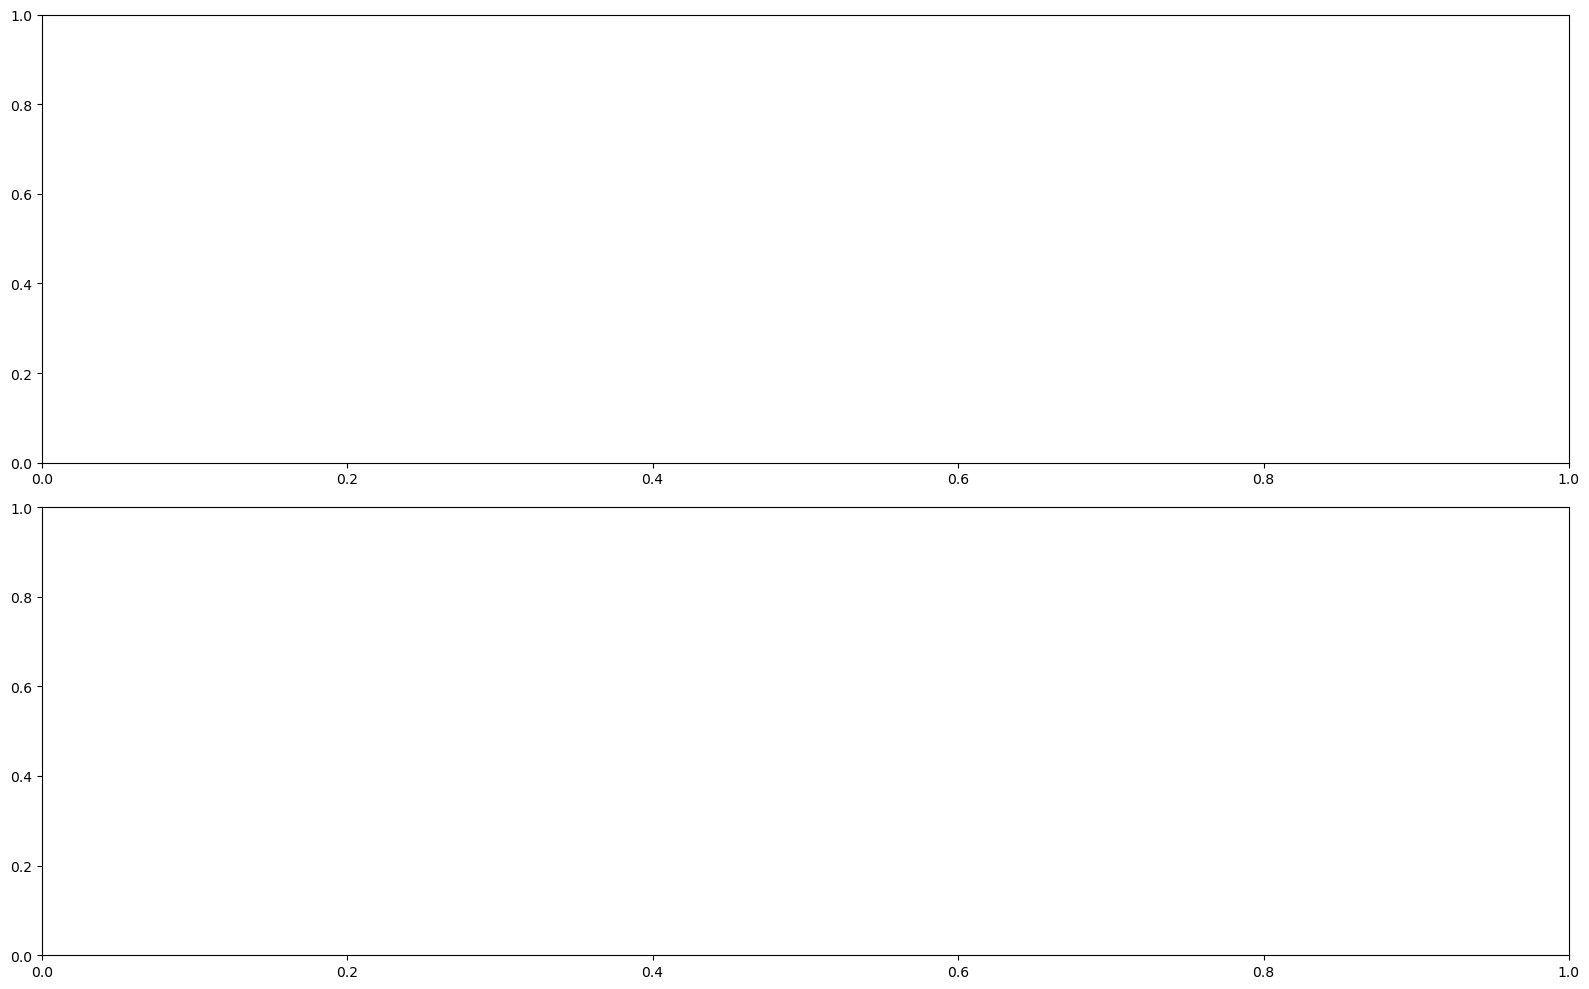

In [38]:
# Create monthly/yearly PM10 heatmaps for each location group
print("="*80)
print("PM10 CALENDAR HEATMAP - MONTHLY & YEARLY PATTERNS BY GROUP")
print("="*80)

# Prepare data: aggregate PM10 (d0 - current day) by month and year for each group
# Get PM10 d0 columns (current day PM10 measurements)
pm10_d0_cols = [col for col in y_train_imputed.columns if 'YPM10-dailymean__d0' in col and 'AVG' not in col]

# Create DataFrames for each group with date index
group_pm10_data = {}

for group_name, group_locs in location_groups.items():
    # Get PM10 columns for this group
    group_pm10_cols = [f"{loc}__YPM10-dailymean__d0" for loc in group_locs 
                       if f"{loc}__YPM10-dailymean__d0" in y_train_imputed.columns]
    
    if group_pm10_cols:
        # Calculate mean PM10 across all locations in the group
        group_pm10_data[group_name] = y_train_imputed[group_pm10_cols].mean(axis=1)

# Convert to DataFrame with proper date index
pm10_by_group = pd.DataFrame(group_pm10_data, index=y_train_imputed.index)

# Add temporal columns
pm10_by_group['year'] = pm10_by_group.index.year
pm10_by_group['month'] = pm10_by_group.index.month
pm10_by_group['year_month'] = pm10_by_group.index.to_period('M')

# Get group names dynamically
group_names = list(location_groups.keys())
if len(group_names) < 2:
    print(f"Warning: Only {len(group_names)} group(s) found. Need at least 2 groups for comparison.")

# Aggregate by year-month for each group
monthly_data = {}
heatmap_data = {}

for group_name in group_names:
    if group_name in pm10_by_group.columns:
        monthly_data[group_name] = pm10_by_group.groupby(['year', 'month'])[group_name].mean().reset_index()
        heatmap_data[group_name] = monthly_data[group_name].pivot(index='year', columns='month', values=group_name)

# Create the heatmap visualization
n_groups = len(group_names)
fig, axes = plt.subplots(n_groups, 1, figsize=(16, 5 * n_groups))
if n_groups == 1:
    axes = [axes]  # Make it iterable

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a heatmap for each group
for idx, group_name in enumerate(group_names):
    if group_name not in heatmap_data:
        continue
    
    heatmap = heatmap_data[group_name]
    ax = axes[idx]
    
    im = ax.imshow(heatmap.values, cmap='YlOrRd', aspect='auto', vmin=0, vmax=50)
    ax.set_xticks(np.arange(len(month_labels)))
    ax.set_yticks(np.arange(len(heatmap.index)))
    ax.set_xticklabels(month_labels, fontsize=11)
    ax.set_yticklabels(heatmap.index, fontsize=11)
    ax.set_title(f'{group_name.title()} ({location_groups[group_name]}) - Monthly Average PM10 (μg/m³)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Month', fontsize=12, fontweight='bold')
    ax.set_ylabel('Year', fontsize=12, fontweight='bold')
    
    # Add text annotations
    for i in range(len(heatmap.index)):
        for j in range(len(month_labels)):
            if j < heatmap.shape[1] and not np.isnan(heatmap.values[i, j]):
                text_color = 'white' if heatmap.values[i, j] > 25 else 'black'
                text = ax.text(j, i, f'{heatmap.values[i, j]:.1f}',
                              ha="center", va="center", color=text_color, 
                              fontsize=9, fontweight='bold')
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('PM10 (μg/m³)', rotation=270, labelpad=20, fontsize=11)

plt.tight_layout()
plt.show()


## Average Correlation Heatmap Across All Stations

This heatmap shows the average correlation between common features across all stations. It helps identify which features are generally correlated regardless of location.

AVERAGE FEATURE CORRELATION ACROSS ALL STATIONS
Added correlation matrix for BIO
Added correlation matrix for BRI
Added correlation matrix for CHI
Added correlation matrix for GIU
Added correlation matrix for LOC
Added correlation matrix for LUG
Added correlation matrix for MEN
Added correlation matrix for NA-MAG

Averaged across 8 stations
Matrix size: 4 features × 4 features


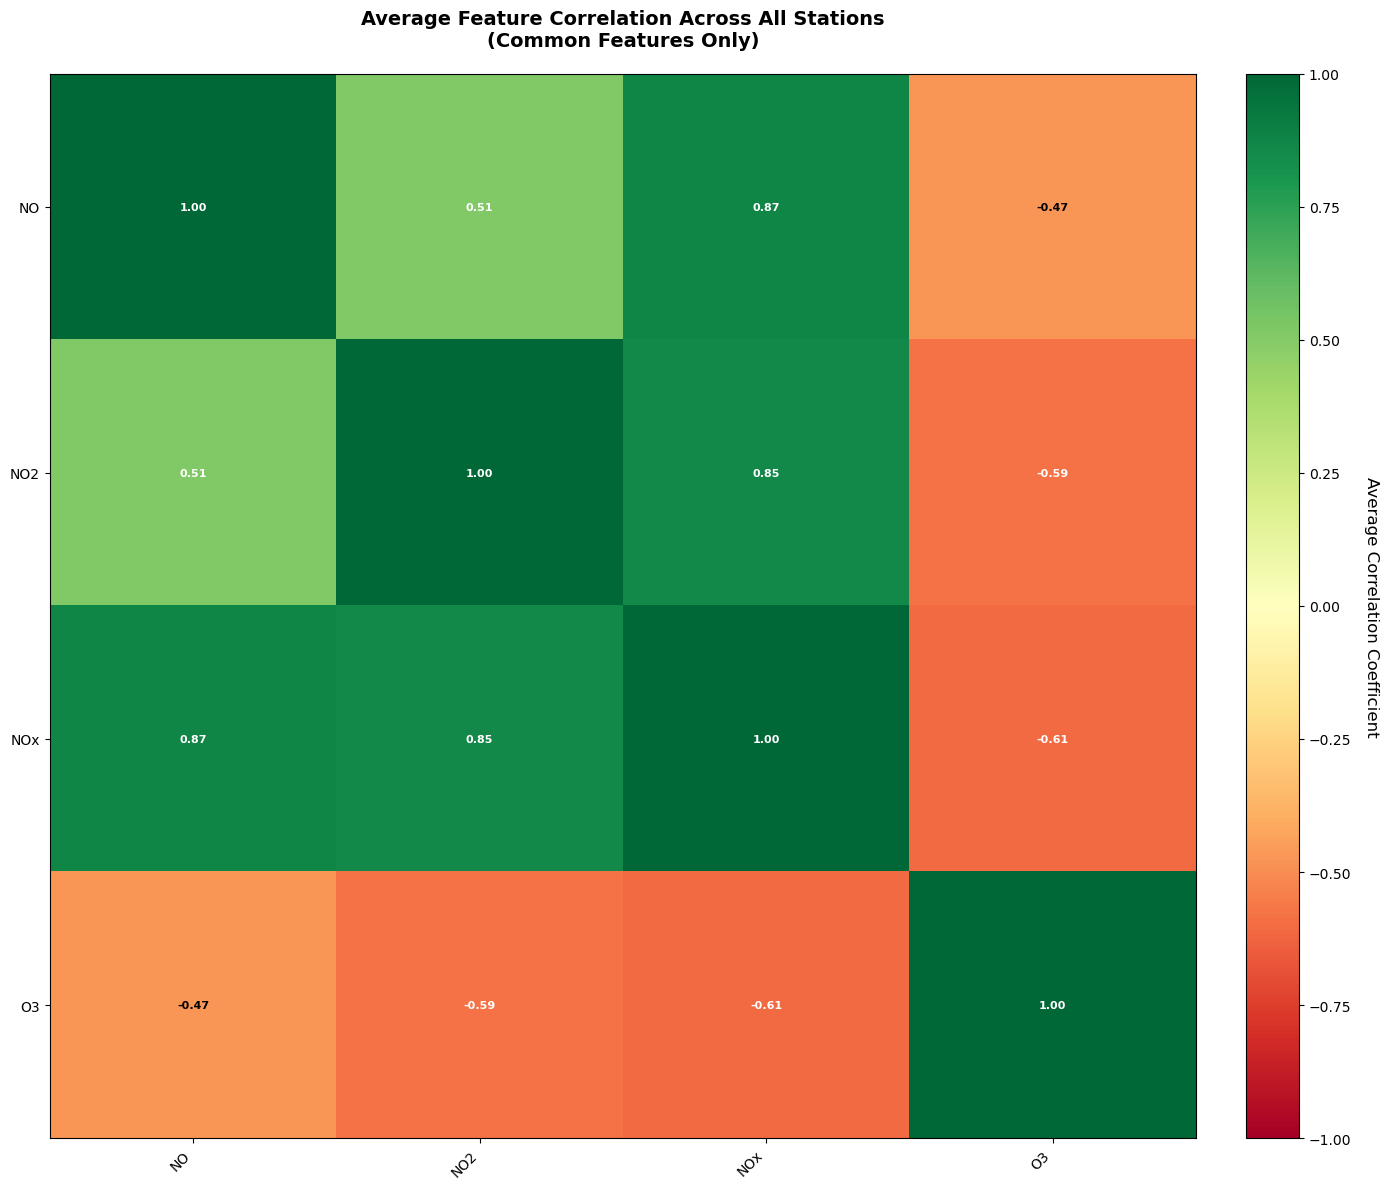

CORRELATION SUMMARY

Highly correlated feature pairs (|r| > 0.7):
  NO <-> NOx: 0.873
  NO2 <-> NOx: 0.853

Total pairs with |r| > 0.7: 2


In [39]:
print("AVERAGE FEATURE CORRELATION ACROSS ALL STATIONS")

# Collect correlation matrices from each station
correlation_matrices = []

# Filter out PM10_lag1 as it doesn't follow the location-based pattern
features_for_correlation = [feat for feat in common_features if feat != 'PM10_lag1']

for loc in locations:
    # Get columns for this location's common features
    loc_cols = [f"{loc}__{feat}__m0" for feat in sorted(features_for_correlation) 
                if f"{loc}__{feat}__m0" in X_train_imputed.columns]
    
    if not loc_cols:
        continue
    
    # Calculate correlation matrix for this station
    station_corr = X_train_imputed[loc_cols].corr()
    
    # Rename columns/index to just feature names for averaging
    station_corr.columns = [col.split('__')[1] for col in station_corr.columns]
    station_corr.index = [col.split('__')[1] for col in station_corr.index]
    
    correlation_matrices.append(station_corr)
    print(f"Added correlation matrix for {loc}")

# Calculate average correlation matrix across all stations
avg_correlation = sum(correlation_matrices) / len(correlation_matrices)

print(f"\nAveraged across {len(correlation_matrices)} stations")
print(f"Matrix size: {avg_correlation.shape[0]} features × {avg_correlation.shape[1]} features")

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))

im = ax.imshow(avg_correlation, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels
features_sorted = sorted(features_for_correlation)
ax.set_xticks(np.arange(len(features_sorted)))
ax.set_yticks(np.arange(len(features_sorted)))
ax.set_xticklabels(features_sorted, fontsize=10, rotation=45, ha='right')
ax.set_yticklabels(features_sorted, fontsize=10)

# Add text annotations
for i in range(len(features_sorted)):
    for j in range(len(features_sorted)):
        text_color = "white" if abs(avg_correlation.iloc[i, j]) > 0.5 else "black"
        text = ax.text(j, i, f'{avg_correlation.iloc[i, j]:.2f}',
                      ha="center", va="center", color=text_color, 
                      fontsize=8, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Average Correlation Coefficient', rotation=270, labelpad=20, fontsize=12)

# Title and layout
ax.set_title('Average Feature Correlation Across All Stations\n(Common Features Only)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print summary statistics
print("CORRELATION SUMMARY")

# Find highly correlated pairs (excluding diagonal)
high_corr_pairs = []
for i in range(len(features_sorted)):
    for j in range(i+1, len(features_sorted)):
        corr_val = avg_correlation.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((features_sorted[i], features_sorted[j], corr_val))

high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print(f"\nHighly correlated feature pairs (|r| > 0.7):")
for feat1, feat2, corr in high_corr_pairs:
    print(f"  {feat1} <-> {feat2}: {corr:.3f}")

print(f"\nTotal pairs with |r| > 0.7: {len(high_corr_pairs)}")

## Remove NOx Feature (Multicollinearity)

Since NOx = NO + NO2, it's redundant and causes multicollinearity (r > 0.85 with both). We'll remove it from our feature set.

In [40]:

# NOx is the sum of NO + NO2, so it's redundant
# Remove it from common_features set
if 'NOx' in common_features:
    common_features.remove('NOx')
    print(" Removed NOx from common_features")
else:
    print("NOx not found in common_features")

# Remove NOx columns from X_train_imputed
nox_cols = [col for col in X_train_imputed.columns if '__NOx__' in col]
if nox_cols:
    X_train_imputed = X_train_imputed.drop(columns=nox_cols)
    print(f" Dropped {len(nox_cols)} NOx columns from X_train_imputed")
else:
    print("No NOx columns found in X_train_imputed")

print(f"\nUpdated common features ({len(common_features)}): {sorted(common_features)}")
print(f"X_train_imputed shape: {X_train_imputed.shape}")

 Removed NOx from common_features
 Dropped 8 NOx columns from X_train_imputed

Updated common features (4): ['NO', 'NO2', 'O3', 'PM10_lag1']
X_train_imputed shape: (2557, 32)


## Average Autocorrelation Analysis Across Stations

This section analyzes the autocorrelation of each common feature by averaging across all stations and displaying confidence bands.

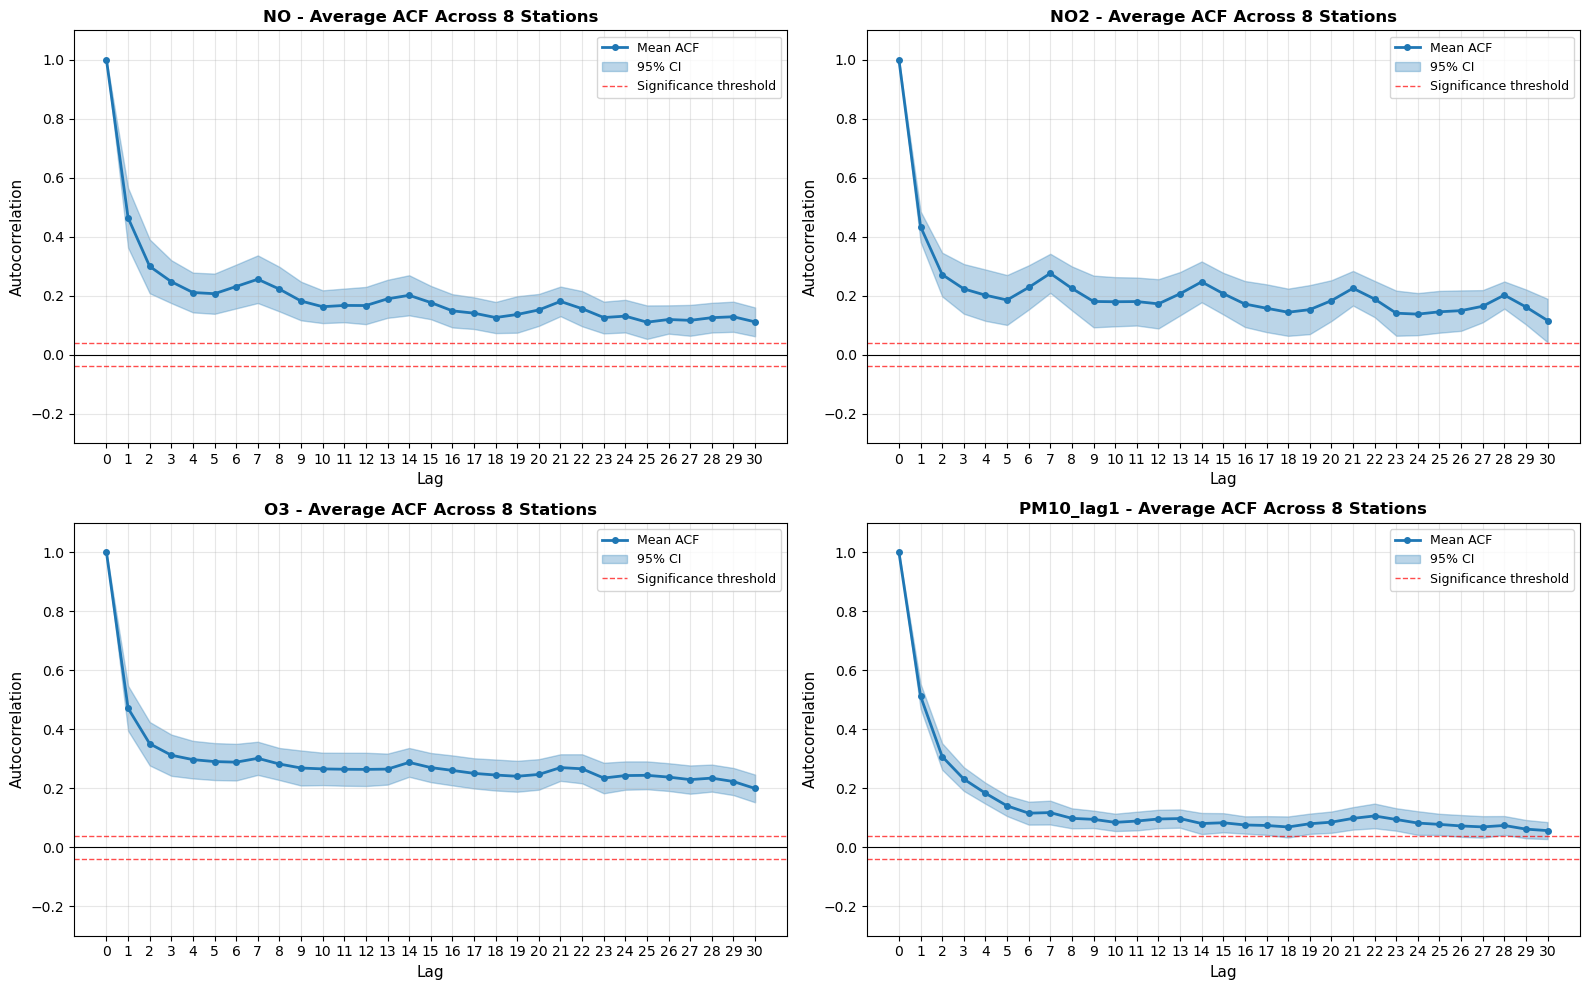

AUTOCORRELATION ANALYSIS SUMMARY

NO:
  Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Total significant lags: 30
  Max ACF (lag>0): 0.464 at lag 1

NO2:
  Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Total significant lags: 30
  Max ACF (lag>0): 0.434 at lag 1

O3:
  Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Total significant lags: 30
  Max ACF (lag>0): 0.471 at lag 1

PM10_lag1:
  Significant lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  Total significant lags: 30
  Max ACF (lag>0): 0.512 at lag 1


In [41]:
from statsmodels.tsa.stattools import acf

from scipy import stats

def plot_average_autocorrelation(data, features, locations, max_lags=40):
    
    # Calculate grid size
    n_features = len(features)
    n_cols = 2
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for idx, feat in enumerate(sorted(features)):
        ax = axes[idx]
        
        # Collect ACF values for this feature across all stations
        acf_values = []
        
        for loc in locations:
            col_name = f"{loc}__{feat}__m0"
            
            if col_name not in data.columns:
                continue
            
            # Get the time series and drop NaN values
            series = data[col_name].dropna()
            
            if len(series) < max_lags + 1:
                continue
            
            # Compute ACF with specified number of lags
            acf_result = acf(series, nlags=max_lags, fft=True)
            acf_values.append(acf_result)
        
        if not acf_values:
            ax.set_visible(False)
            continue
        
        # Convert to numpy array for easier computation
        acf_array = np.array(acf_values)  # Shape: (n_stations, n_lags+1)
        
        # Calculate mean and standard error across stations
        mean_acf = np.mean(acf_array, axis=0)
        std_acf = np.std(acf_array, axis=0)
        se_acf = std_acf / np.sqrt(len(acf_values))  # Standard error
        
        # 95% confidence interval
        ci_95 = 1.96 * se_acf
        
        # Lags
        lags = np.arange(len(mean_acf))
        
        # Plot mean ACF
        ax.plot(lags, mean_acf, 'o-', color='#1f77b4', linewidth=2, 
                markersize=4, label='Mean ACF', zorder=3)
        
        # Plot confidence band
        ax.fill_between(lags, mean_acf - ci_95, mean_acf + ci_95, 
                        alpha=0.3, color='#1f77b4', label='95% CI')
        
        # Add significance threshold (1.96/sqrt(n))
        n_obs = len(data[f"{locations[0]}__{feat}__m0"].dropna())
        significance_level = 1.96 / np.sqrt(n_obs)
        ax.axhline(y=significance_level, color='red', linestyle='--', 
                   linewidth=1, alpha=0.7, label='Significance threshold')
        ax.axhline(y=-significance_level, color='red', linestyle='--', 
                   linewidth=1, alpha=0.7)
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
        
        # Formatting
        ax.set_xlabel('Lag', fontsize=11)
        ax.set_ylabel('Autocorrelation', fontsize=11)
        ax.set_title(f'{feat} - Average ACF Across {len(acf_values)} Stations', 
                     fontsize=12, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.legend(fontsize=9, loc='upper right')
        ax.set_ylim(-0.3, 1.1)
        
        # Increase x-axis granulation with more frequent ticks
        ax.set_xticks(np.arange(0, len(lags), 1))  # Tick every 5 lags
        ax.set_xticklabels(np.arange(0, len(lags), 1))
    
    # Hide unused subplots
    for idx in range(n_features, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("AUTOCORRELATION ANALYSIS SUMMARY")
    
    # Analyze significant lags for each feature
    for feat in sorted(features):
        acf_values = []
        
        for loc in locations:
            col_name = f"{loc}__{feat}__m0"
            if col_name in data.columns:
                series = data[col_name].dropna()
                if len(series) >= max_lags + 1:
                    acf_result = acf(series, nlags=max_lags, fft=True)
                    acf_values.append(acf_result)
        
        if not acf_values:
            continue
        
        acf_array = np.array(acf_values)
        mean_acf = np.mean(acf_array, axis=0)
        
        # Find significant lags (beyond lag 0)
        n_obs = len(data[f"{locations[0]}__{feat}__m0"].dropna())
        significance_level = 1.96 / np.sqrt(n_obs)
        significant_lags = np.where(np.abs(mean_acf[1:]) > significance_level)[0] + 1
        
        if len(significant_lags) > 0:
            print(f"\n{feat}:")
            print(f"  Significant lags: {significant_lags[:10].tolist()}")
            print(f"  Total significant lags: {len(significant_lags)}")
            print(f"  Max ACF (lag>0): {np.max(np.abs(mean_acf[1:])):.3f} at lag {np.argmax(np.abs(mean_acf[1:])) + 1}")
    

# Call the function with our data
plot_average_autocorrelation(X_train_imputed, common_features, locations, max_lags=30)

For each feature between locations the dataset shows moderate correlation up until the third/fourth lag , after which the correlation drops significantly. There are clearly weekly seasonality patterns in the data. 

In [42]:
# check stationarity using ADF test for all common features averaged across locations
from statsmodels.tsa.stattools import adfuller
print("STATIONARITY ANALYSIS USING ADF TEST\n")
for feat in sorted(common_features):
    adf_results = []
    
    for loc in locations:
        col_name = f"{loc}__{feat}__m0"
        
        if col_name not in X_train_imputed.columns:
            continue
        
        series = X_train_imputed[col_name].dropna()
        
        if len(series) < 30:  # Require at least 30 data points
            continue
        
        adf_result = adfuller(series)
        adf_results.append(adf_result)
    
    if not adf_results:
        print(f"{feat}: No valid stations for ADF test")
        continue
    
    # Aggregate results
    p_values = [result[1] for result in adf_results]
    avg_p_value = np.mean(p_values)
    
    print(f"{feat}: Average ADF p-value across {len(adf_results)} stations = {avg_p_value:.4f} ", end='')
    if avg_p_value < 0.05:
        print("(Stationary)")
    else:
        print("(Non-Stationary)")

STATIONARITY ANALYSIS USING ADF TEST

NO: Average ADF p-value across 8 stations = 0.0000 (Stationary)
NO2: Average ADF p-value across 8 stations = 0.0000 (Stationary)
O3: Average ADF p-value across 8 stations = 0.0006 (Stationary)
PM10_lag1: Average ADF p-value across 8 stations = 0.0000 (Stationary)


In [43]:
X_train_imputed.columns

Index(['BIO__PM10_lag1__m0', 'BRI__PM10_lag1__m0', 'CHI__PM10_lag1__m0',
       'GIU__PM10_lag1__m0', 'LOC__PM10_lag1__m0', 'LUG__PM10_lag1__m0',
       'MEN__PM10_lag1__m0', 'NA-MAG__PM10_lag1__m0', 'BIO__O3__m0',
       'BRI__O3__m0', 'CHI__O3__m0', 'GIU__O3__m0', 'LOC__O3__m0',
       'LUG__O3__m0', 'MEN__O3__m0', 'NA-MAG__O3__m0', 'BIO__NO__m0',
       'BRI__NO__m0', 'CHI__NO__m0', 'GIU__NO__m0', 'LOC__NO__m0',
       'LUG__NO__m0', 'MEN__NO__m0', 'NA-MAG__NO__m0', 'BIO__NO2__m0',
       'BRI__NO2__m0', 'CHI__NO2__m0', 'GIU__NO2__m0', 'LOC__NO2__m0',
       'LUG__NO2__m0', 'MEN__NO2__m0', 'NA-MAG__NO2__m0'],
      dtype='object')

# 2. Modeling Framework

## Train/Validation Split

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

val_size = 30
X_train_split = X_train_imputed.iloc[:-val_size]
X_val_split = X_train_imputed.iloc[-val_size:]
y_train_split = y_train_imputed.iloc[:-val_size]
y_val_split = y_train_imputed.iloc[-val_size:]

#check size
print(f"\nTraining set shape: {X_train_split.shape}, {y_train_split.shape}")
print(f"Validation set shape: {X_val_split.shape}, {y_val_split.shape}")


Training set shape: (2527, 32), (2527, 6)
Validation set shape: (30, 32), (30, 6)


## Base Model Class

In [45]:
from abc import ABC, abstractmethod

class BaseModel(ABC):
    def __init__(self, name):
        self.name = name
        self.is_fitted = False
    
    @abstractmethod
    def fit(self, X, y):
        pass
    
    @abstractmethod
    def predict(self, X):
        pass
    
    def predict_quantiles(self, X, quantiles=[0.1, 0.5, 0.9]):
        return {q: self.predict(X) for q in quantiles}
    
    def evaluate(self, y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

## Naive Models

In [46]:
class NaiveModel(BaseModel):
    def __init__(self, strategy='last'):
        super().__init__(f'Naive-{strategy}')
        self.strategy = strategy
        self.last_values = None
        self.residuals = None
    
    def fit(self, X, y):
        if self.strategy == 'last':
            self.last_values = y.iloc[-1]
        elif self.strategy == 'seasonal':
            self.last_values = y.iloc[-7:]
        elif self.strategy == 'drift':
            self.last_values = y.iloc[-1]
            self.drift = (y.iloc[-1] - y.iloc[0]) / len(y)
        
        y_pred = self.predict(X)
        self.residuals = y - y_pred
        self.is_fitted = True
        return self
    
    def predict(self, X):
        n = len(X)
        
        if self.strategy == 'last':
            return pd.DataFrame(
                np.repeat([self.last_values.values], n, axis=0),
                index=X.index, columns=self.last_values.index
            )
        elif self.strategy == 'seasonal':
            preds = []
            for i in range(n):
                preds.append(self.last_values.iloc[i % 7].values)
            return pd.DataFrame(preds, index=X.index, columns=self.last_values.columns)
        elif self.strategy == 'drift':
            preds = []
            for i in range(1, n + 1):
                preds.append((self.last_values + i * self.drift).values)
            return pd.DataFrame(preds, index=X.index, columns=self.last_values.index)
    
    def predict_quantiles(self, X, quantiles=[0.1, 0.5, 0.9]):
        point_pred = self.predict(X)
        results = {}
        
        for q in quantiles:
            if self.residuals is not None:
                q_values = self.residuals.quantile(q)
                results[q] = point_pred + q_values
            else:
                results[q] = point_pred
        
        return results

## SARIMA Models

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

class SARIMAModel(BaseModel):
    def __init__(self, order=(1,0,1), seasonal_order=(1,0,1,7)):
        super().__init__('SARIMA')
        self.order = order
        self.seasonal_order = seasonal_order
        self.models = {}
    
    def fit(self, X, y):
        for col in y.columns:
            try:
                model = SARIMAX(
                    y[col],
                    order=self.order,
                    seasonal_order=self.seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                self.models[col] = model.fit(disp=False, maxiter=100)
            except:
                self.models[col] = None
        
        self.is_fitted = True
        return self
    
    def predict(self, X):
        predictions = {}
        start_idx = len(X) + len(self.models[list(self.models.keys())[0]].data.orig_endog)
        end_idx = start_idx + len(X) - 1
        
        for col, model in self.models.items():
            if model is not None:
                try:
                    pred = model.predict(start=start_idx, end=end_idx)
                    predictions[col] = pred.values
                except:
                    predictions[col] = np.full(len(X), np.nan)
            else:
                predictions[col] = np.full(len(X), np.nan)
        
        return pd.DataFrame(predictions, index=X.index)
    
    def predict_quantiles(self, X, quantiles=[0.1, 0.5, 0.9]):
        results = {}
        start_idx = len(X) + len(self.models[list(self.models.keys())[0]].data.orig_endog)
        end_idx = start_idx + len(X) - 1
        
        for q in quantiles:
            predictions = {}
            for col, model in self.models.items():
                if model is not None:
                    try:
                        forecast = model.get_forecast(steps=len(X))
                        pred_int = forecast.conf_int(alpha=1-q)
                        if q < 0.5:
                            predictions[col] = pred_int.iloc[:, 0].values
                        elif q > 0.5:
                            predictions[col] = pred_int.iloc[:, 1].values
                        else:
                            predictions[col] = forecast.predicted_mean.values
                    except:
                        predictions[col] = np.full(len(X), np.nan)
                else:
                    predictions[col] = np.full(len(X), np.nan)
            results[q] = pd.DataFrame(predictions, index=X.index)
        
        return results

## LightGBM Models

In [48]:
import lightgbm as lgb

def create_lag_features(X, y_train, lags=[1, 7, 14]):
    X_features = X.copy()
    
    # Get PM10 measurement columns (m0)
    pm10_cols = [c for c in X.columns if 'YPM10' in c and '__m0' in c]
    
    # Add lag features
    for lag in lags:
        for col in pm10_cols:
            lag_name = f'{col}_lag{lag}'
            if lag < len(y_train):
                # Use historical training data for lags
                X_features[lag_name] = np.nan
    
    # Add rolling statistics
    for col in pm10_cols:
        X_features[f'{col}_rolling7_mean'] = np.nan
        X_features[f'{col}_rolling7_std'] = np.nan
    
    # Add temporal features
    X_features['dayofweek'] = X.index.dayofweek
    X_features['month'] = X.index.month
    X_features['dayofyear'] = X.index.dayofyear
    
    return X_features

class LGBMModel(BaseModel):
    def __init__(self, objective='regression'):
        super().__init__('LightGBM')
        self.objective = objective
        self.models = {}
        self.feature_cols = None
    
    def fit(self, X, y):
        X_features = create_lag_features(X, y)
        
        # Fill lag features with training data
        pm10_cols = [c for c in X.columns if 'YPM10' in c and '__m0' in c]
        for lag in [1, 7, 14]:
            for col in pm10_cols:
                lag_name = f'{col}_lag{lag}'
                if lag_name in X_features.columns:
                    X_features[lag_name] = X[col].shift(lag)
        
        # Fill rolling features
        for col in pm10_cols:
            X_features[f'{col}_rolling7_mean'] = X[col].rolling(7, min_periods=1).mean()
            X_features[f'{col}_rolling7_std'] = X[col].rolling(7, min_periods=1).std()
        
        X_features = X_features.fillna(0)
        self.feature_cols = X_features.columns
        
        # Train separate model for each target column
        for col in y.columns:
            params = {
                'objective': self.objective,
                'metric': 'mae',
                'verbosity': -1,
                'n_estimators': 100,
                'learning_rate': 0.05,
                'max_depth': 5
            }
            
            model = lgb.LGBMRegressor(**params)
            model.fit(X_features, y[col])
            self.models[col] = model
        
        self.is_fitted = True
        return self
    
    def predict(self, X):
        X_features = X.copy()
        
        # Add temporal features
        X_features['dayofweek'] = X.index.dayofweek
        X_features['month'] = X.index.month
        X_features['dayofyear'] = X.index.dayofyear
        
        # Add missing feature columns with zeros
        for col in self.feature_cols:
            if col not in X_features.columns:
                X_features[col] = 0
        
        X_features = X_features[self.feature_cols]
        
        predictions = {}
        for col, model in self.models.items():
            predictions[col] = model.predict(X_features)
        
        return pd.DataFrame(predictions, index=X.index)
    
    def predict_quantiles(self, X, quantiles=[0.1, 0.5, 0.9]):
        # Train quantile models
        quantile_preds = {}
        
        for q in quantiles:
            if q == 0.5:
                quantile_preds[q] = self.predict(X)
            else:
                # Use simple scaling based on residual distribution
                point_pred = self.predict(X)
                scale = 1.5 if q > 0.5 else 0.5
                quantile_preds[q] = point_pred * scale
        
        return quantile_preds

## Model Training

In [49]:
models = {
    'Naive-Last': NaiveModel(strategy='last'),
    'Naive-Seasonal': NaiveModel(strategy='seasonal'),
    'Naive-Drift': NaiveModel(strategy='drift'),
    # 'SARIMA': SARIMAModel(),
    # 'LightGBM': LGBMModel()
}

for name, model in models.items():
    model.fit(X_train_split, y_train_split)

## Validation Predictions

In [50]:
predictions = {}
quantile_predictions = {}

for name, model in models.items():
    predictions[name] = model.predict(X_val_split)
    quantile_predictions[name] = model.predict_quantiles(X_val_split, quantiles=[0.1, 0.5, 0.9])

## Performance Metrics

In [51]:
results = []

for name, pred in predictions.items():
    for col in y_val_split.columns:
        y_true = y_val_split[col].values
        y_pred = pred[col].values
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
        
        location = col.split('__')[0]
        horizon = col.split('__')[-1]
        
        results.append({
            'Model': name,
            'Location': location,
            'Horizon': horizon,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        })

results_df = pd.DataFrame(results)

## Model Comparison

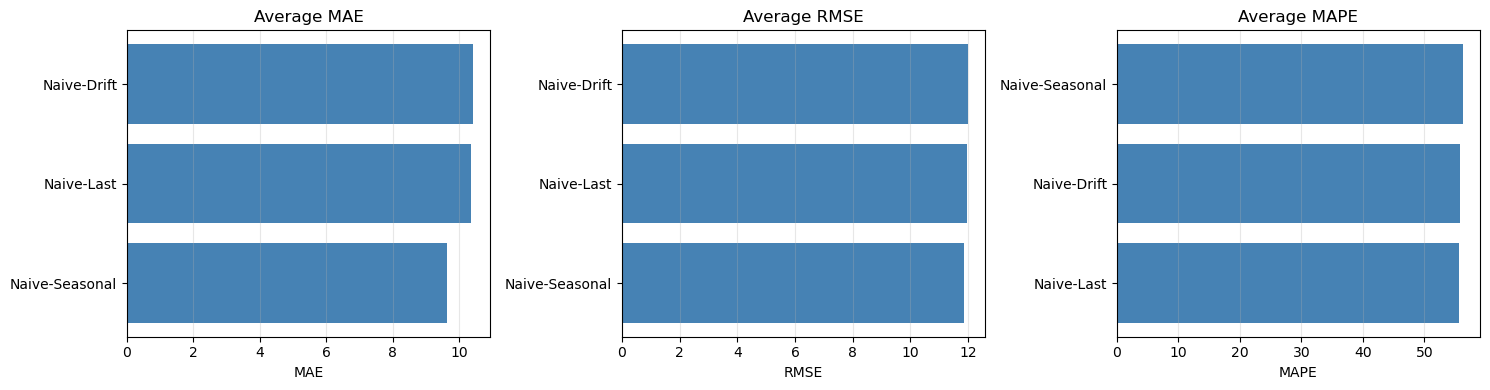

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, metric in enumerate(['MAE', 'RMSE', 'MAPE']):
    avg_metric = results_df.groupby('Model')[metric].mean().sort_values()
    
    axes[idx].barh(avg_metric.index, avg_metric.values, color='steelblue')
    axes[idx].set_xlabel(metric)
    axes[idx].set_title(f'Average {metric}')
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## Forecast Visualization - Point Estimates

KeyError: 'BRI__YPM10-dailymean__d3'

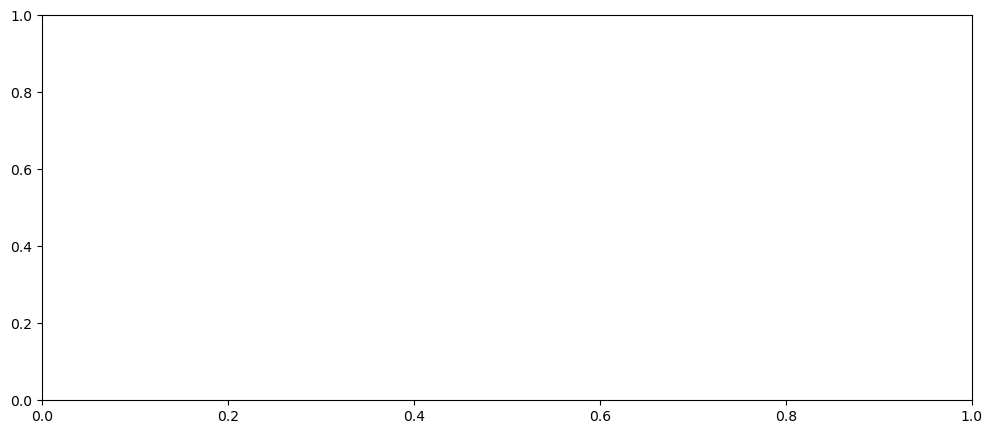

In [53]:
sample_location = 'BRI'
sample_horizon = 'd3'
sample_col = f'{sample_location}__YPM10-dailymean__{sample_horizon}'

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(y_val_split.index, y_val_split[sample_col], 'o-', label='Actual', color='black', linewidth=2)

for name, pred in predictions.items():
    ax.plot(pred.index, pred[sample_col], '--', label=name, alpha=0.7)

ax.set_xlabel('Date')
ax.set_ylabel('PM10')
ax.set_title(f'Forecast Comparison: {sample_location} - {sample_horizon}')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Probabilistic Forecasts

KeyError: 'SARIMA'

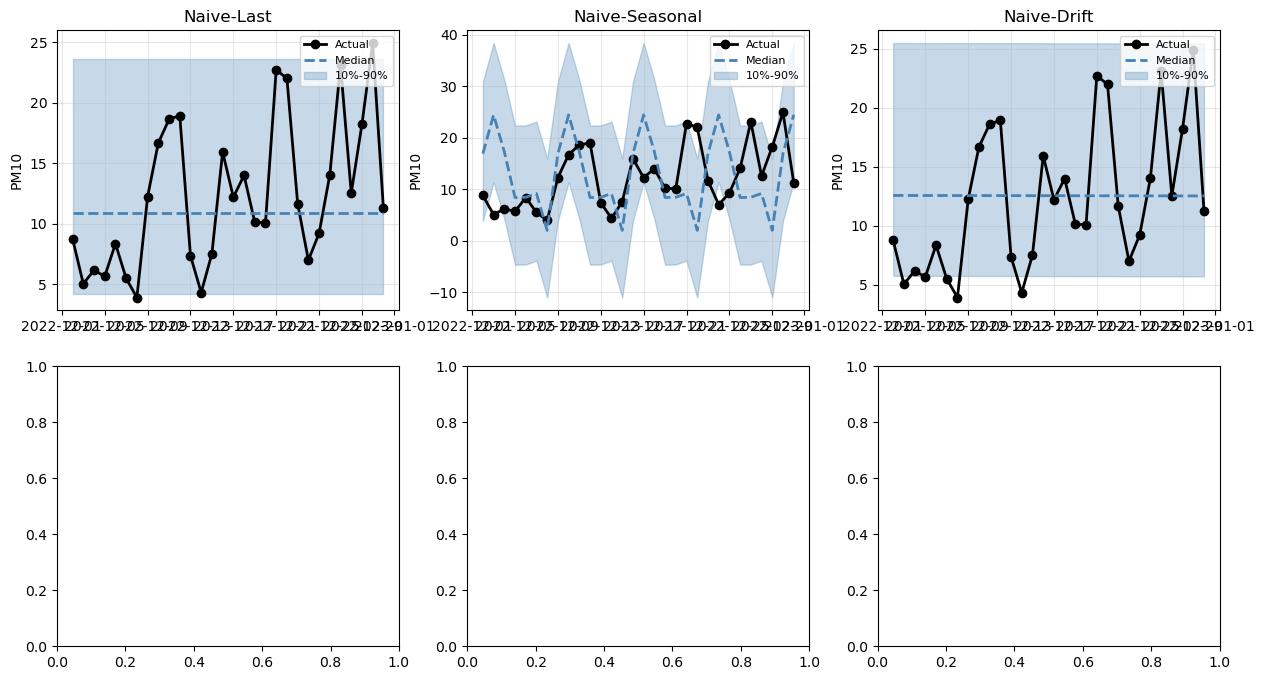

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

model_names = ['Naive-Last', 'Naive-Seasonal', 'Naive-Drift', 'SARIMA', 'LightGBM']

for idx, name in enumerate(model_names):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    
    quantiles = quantile_predictions[name]
    
    ax.plot(y_val_split.index, y_val_split[sample_col], 'o-', label='Actual', color='black', linewidth=2)
    ax.plot(quantiles[0.5].index, quantiles[0.5][sample_col], '--', label='Median', color='steelblue', linewidth=2)
    
    ax.fill_between(
        quantiles[0.1].index,
        quantiles[0.1][sample_col],
        quantiles[0.9][sample_col],
        alpha=0.3,
        color='steelblue',
        label='10%-90%'
    )
    
    ax.set_title(f'{name}')
    ax.set_ylabel('PM10')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(alpha=0.3)

axes[-1].axis('off')
plt.suptitle(f'Probabilistic Forecasts: {sample_location} - {sample_horizon}')
plt.tight_layout()
plt.show()

## Performance by Horizon

In [ ]:
horizon_performance = results_df.groupby(['Horizon', 'Model'])['MAE'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 5))

horizons = sorted(horizon_performance['Horizon'].unique())
x = np.arange(len(horizons))
width = 0.15

for idx, model in enumerate(models.keys()):
    model_data = horizon_performance[horizon_performance['Model'] == model]
    values = [model_data[model_data['Horizon'] == h]['MAE'].values[0] if len(model_data[model_data['Horizon'] == h]) > 0 else 0 for h in horizons]
    ax.bar(x + idx * width, values, width, label=model)

ax.set_xlabel('Horizon')
ax.set_ylabel('MAE')
ax.set_title('Model Performance by Forecast Horizon')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(horizons)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Performance by Location

In [ ]:
location_performance = results_df.groupby(['Location', 'Model'])['MAE'].mean().reset_index()
pivot_table = location_performance.pivot(index='Location', columns='Model', values='MAE')

fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(pivot_table.values, cmap='RdYlGn_r', aspect='auto')

ax.set_xticks(np.arange(len(pivot_table.columns)))
ax.set_yticks(np.arange(len(pivot_table.index)))
ax.set_xticklabels(pivot_table.columns, rotation=45, ha='right')
ax.set_yticklabels(pivot_table.index)

for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        text = ax.text(j, i, f'{pivot_table.values[i, j]:.1f}',
                      ha='center', va='center', color='black', fontsize=9)

ax.set_title('MAE by Location and Model')
plt.colorbar(im, ax=ax, label='MAE')
plt.tight_layout()
plt.show()